In [1]:
# author:     Yike Xie
# date:       09/09/21
# content:    Get interactions between immune cells and endothelial cells for sick and healthy

In [2]:
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
import itertools
from numpy import *    

In [3]:
import sys
sys.path.append('/home/yike/phd/dengue/dengue_children') #enter the YK_util file directory
import YK_util, optimized_pair_comparison
from YK_util import *
from optimized_pair_comparison import *

# get basic information of dengue kid immune cells

In [4]:
#initiate the dataset, select monocytes in kids only
path = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = getdata(path)
adata_kid = subsetdata(adata)
adata_kid = normalizedata(adata_kid) # log1p=2
adata_kid = removegenes(adata_kid)

In [5]:
print('split condition to sick and Healthy')
adata_kid.obs['sick'] = adata_kid.obs['Condition'].replace({
                                                            'S_dengue': 'sick',
                                                            'dengue': 'sick',
                                                            'DWS': 'sick'
                                                        })

split condition to sick and Healthy


In [6]:
cts = adata_kid.obs['cell_type'].astype('category').cat.categories.tolist()
csts = adata_kid.obs['cell_subtype_2'].astype('category').cat.categories.tolist()
csts.remove('doublets')
csts.remove('pDCs')

In [7]:
def pair_comparison(adata, cell_types, log1p=False):    

    ress = pd.DataFrame([])
    log2FC = pd.DataFrame([])
    
    cds = ['Healthy', 'sick']
    
    if 'donor' in adata.obs.columns:
        p_ID = 'donor'
    elif 'ID' in adata.obs.columns:
        p_ID = 'ID'
        
    adata_cd = {cd: (adata[adata.obs['sick'] == cd]) for cd in cds}
    
    for cell_type in cell_types:
        ct_obs = 'cell_subtype_2'
        if cell_type in adata.obs['cell_type'].unique():
            ct_obs = 'cell_type'
        
        adata_S_ct = adata_cd[cds[1]][adata_cd[cds[1]].obs[ct_obs] == cell_type]
        adata_NS_ct = adata_cd[cds[0]][adata_cd[cds[0]].obs[ct_obs] == cell_type]
        
        IDs_S = list(adata_S_ct.obs[p_ID].astype('category').cat.categories)
        IDs_NS = list(adata_NS_ct.obs[p_ID].astype('category').cat.categories)

        log2_fc = []
        for ID_S in IDs_S:
            adata_S_ID = adata_S_ct[adata_S_ct.obs[p_ID] == ID_S]
            if len(adata_S_ID.obs_names) < 5:
                continue
            for ID_NS in IDs_NS:
                adata_NS_ID = adata_NS_ct[adata_NS_ct.obs[p_ID] == ID_NS]
                if len(adata_NS_ID.obs_names) < 5:
                    continue

                X_S = adata_S_ID.X
                X_NS = adata_NS_ID.X
                avg_S = np.asarray(X_S.mean(axis=0))[0]
                avg_NS = np.asarray(X_NS.mean(axis=0))[0]
                
                if log1p is False:
                    log2_fc.append(np.log2(avg_S + 1) - np.log2(avg_NS + 1))
                elif log1p not in (True, 2):
                    log2_fc.append((avg_S - avg_NS) / np.log2(log1p))
                else:
                    log2_fc.append(avg_S - avg_NS)

        log2_fc = np.asarray(log2_fc)
        if log2_fc.size == 0:
            continue
        med_pair = np.median(log2_fc, axis=0)
        fra_pair = [len(log2_fc[:, i][log2_fc[:, i] > 0])/log2_fc.shape[0] for i in range(log2_fc.shape[1])]

        res = pd.DataFrame([], index=adata_S_ct.var_names)
        res['med_pair'] = med_pair
        res['fra_pair'] = fra_pair
        res['cell_subtype'] = cell_type
        ress = pd.concat([ress, res])
        ress['gene'] = ress.index.tolist()

        FCs = pd.DataFrame(log2_fc, columns = adata_S_ct.var_names, index=[cell_type] * log2_fc.shape[0])
        log2FC = pd.concat([log2FC, FCs])
        
    return {'pair_res': ress, 'log_FCs': log2FC}

def fra_avg(adata, cell_types, log1p=False):    

    fra = pd.DataFrame([])
    avg = pd.DataFrame([])
    
    cds = ['Healthy', 'sick']
    p_ID = 'ID'

    adata_cd = {cd: (adata[adata.obs['sick'] == cd]) for cd in cds}

    for cell_type in cell_types:
        ct_obs = 'cell_subtype_2'
        if cell_type in adata.obs['cell_type'].unique():
            ct_obs = 'cell_type'
        
        for cd in cds:
            if cell_type not in adata_cd[cd].obs[ct_obs].unique():
                continue
            adata_ct = adata_cd[cd][adata_cd[cd].obs[ct_obs] == cell_type]
            IDs = list(adata_ct.obs[p_ID].astype('category').cat.categories)

            for ID in IDs:
                adata_ID = adata_ct[adata_ct.obs[p_ID] == ID]
                if len(adata_ID.obs_names) < 5:
                    IDs.remove(ID)  
            adata_ct = adata_ct[adata_ct.obs[p_ID].isin(IDs)]
            
            if adata_ct.obs.shape[0] == 0:
                continue
            fra_ct = np.asarray((adata_ct.X > 0).mean(axis=0))[0]
            fra_ct = pd.DataFrame(fra_ct, columns=['fra'], index=adata_ct.var_names)
            fra_ct[ct_obs] = cell_type
            fra_ct['condition'] = cd
            fra = pd.concat([fra, fra_ct])
            fra['gene'] = fra.index.tolist()

            avg_ct = np.asarray(adata_ct.X.mean(axis=0))[0]
                        
            if log1p == 2:
                avg_ct = np.exp2(avg_ct) -1
            elif log1p not in (True, 2):
                avg_ct = np.exp2(np.log2(log1p) * avg_ct) - 1
   
            avg_ct = pd.DataFrame(avg_ct, columns=['avg'], index=adata_ct.var_names)
            avg_ct[ct_obs] = cell_type
            avg_ct['condition'] = cd
            avg = pd.concat([avg, avg_ct])
            avg['gene'] = avg.index.tolist()
            
    return {'fra': fra, 'avg': avg}

def combination(pair, fra, avg):
    '''
    fra.index = ['cell_subtype_2', 'gene']
    '''
    pair = pair.set_index(['cell_subtype', 'gene'])
    
    ct = 'cell_type'
    if 'cell_subtype_2' in fra.columns:
        ct = 'cell_subtype_2'
    fra = fra.set_index([ct, 'gene', 'condition'])
    avg = avg.set_index([ct, 'gene', 'condition'])
    
    NS, S = 'Healthy', 'sick'
        
    NS_idx = [(i[0], i[1], NS) for i in pair.index]
    S_idx = [(i[0], i[1], S) for i in pair.index]
    
    pair['S_fra'] = (fra.loc[S_idx])['fra'].tolist()
    pair['NS_fra'] = (fra.loc[NS_idx])['fra'].tolist()
    
    pair['S_avg'] = (avg.loc[S_idx])['avg'].tolist()
    pair['NS_avg'] = (avg.loc[NS_idx])['avg'].tolist()
    
    return pair

In [197]:
pair = pair_comparison(adata_kid, cts, log1p=2)
pair['pair_res'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_ct_pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_ct_log2FC.tsv', sep='\t')

fra_av = fra_avg(adata_kid, cts, log1p=2)
fra_av['fra'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_fra.tsv', sep='\t', index=False)
fra_av['avg'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_avg.tsv', sep='\t', index=False)

data = combination(pair['pair_res'], fra_av['fra'], fra_av['fra'])
data.to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_ct_data_pair.tsv', sep='\t')

In [64]:
pair = pair_comparison(adata_kid, csts, log1p=2)
pair['pair_res'].to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_cst_pair.tsv', sep='\t', index=False)
pair['log_FCs'].to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_cst_log2FC.tsv', sep='\t')

fra_av = fra_avg(adata_kid, csts, log1p=2)
fra_av['fra'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_fra_cst.tsv', sep='\t', index=False)
fra_av['avg'].to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_avg_cst.tsv', sep='\t', index=False)

data = combination(pair['pair_res'], fra_av['fra'], fra_av['avg'])
data.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_cst_data_pair.tsv', sep='\t')

In [65]:
im_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_ct_data_pair.tsv',
                    sep='\t', index_col=['cell_subtype', 'gene'])
im_subct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_cst_data_pair.tsv',
                    sep='\t', index_col=['cell_subtype', 'gene'])

In [38]:
import anndataks
subcts = cts + csts
subcts.remove('cDC_IFN')
conditions = ['sick', 'Healthy']

results = {}
for subct in subcts:
    if subct in adata_kid.obs['cell_type'].astype('category').cat.categories:
        adata_ct = adata_kid[adata_kid.obs['cell_type'] == subct]
    elif subct in adata_kid.obs['cell_subtype_2'].astype('category').cat.categories:
        adata_ct = adata_kid[adata_kid.obs['cell_subtype_2'] == subct]
        
    adata_SD = adata_ct[adata_ct.obs['sick'] == 'sick']
    adata_D = adata_ct[adata_ct.obs['sick'] == 'Healthy']
    # while calculating ks test pvalue, the adata is log1ped, so the argument log1p=2
    results[subct] = anndataks.compare(adata_D, adata_SD, log1p=2) # log2_fold_change: adata_Sd vs adata_D

ks_res = pd.DataFrame([])
for subct in subcts:
    results[subct]['cell_subtype'] = [subct] * results[subct].shape[0]
    ks_res = pd.concat([ks_res, results[subct]])

ks_res.set_index(['cell_subtype', ks_res.index], inplace=True)
ks_res.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_ks_pvalue.tsv', sep='\t')

ks_res = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_ks_pvalue.tsv', sep='\t', index_col=['cell_subtype', 'gene'])
im_subct = pd.concat([im_subct, ks_res.loc[im_subct.index]], axis=1)
im_subct.to_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_cst_data_pair_p.tsv', sep='\t')

im_ct = pd.concat([im_ct, ks_res.loc[im_ct.index]], axis=1)
im_ct.to_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_ct_data_pair_p.tsv', sep='\t')

1


# get interaction with endothelial cells at sick or Healthy

In [43]:
adata_endo = sc.read_h5ad('/home/yike/phd/dataset_from_google/Tabula_Sapiens_Single_Cell_Dataset/TS_Endothelial.h5ad')
adata_endo = normalizedata(adata_endo, log1p=False) # didn't log1p
adata_endo = removegenes(adata_endo)

In [44]:
fra_avg_ed = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg.tsv', sep='\t', index_col='gene')
fra_avg_ed_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg_cst.tsv', sep='\t', index_col=['cell_subtype', 'gene'])

In [45]:
print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]
genes = np.unique(interactions)
print('filter interaction genes in immune and endo dataset')
im_genes = [i for i in genes if i in adata.var_names] 
ed_genes = [i for i in genes if i in adata_endo.var_names] 

Load interaction
filter interaction genes in immune and endo dataset


In [107]:
def endo_inters(cell_types, cds, fra_n):
    fra_avg_ed = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg.tsv', sep='\t', index_col='gene')

    fra_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_fra.tsv', sep='\t', index_col=
                         ['cell_type', 'condition', 'gene'], squeeze=True)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_avg.tsv', sep='\t', index_col=
                         ['cell_type', 'condition', 'gene'], squeeze=True)

    fra_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_fra.tsv', sep='\t', index_col=
                         ['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    avg_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_avg.tsv', sep='\t', index_col=
                         ['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    
    inters_endo = []
    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']

        for cell_type in cell_types:
            if cell_type in adata_kid.obs['cell_type'].astype('category').cat.categories:
                fra = fra_ct.loc[cell_type]
                avg = avg_ct.loc[cell_type]
            elif cell_type in adata_kid.obs['cell_subtype_2'].astype('category').cat.categories:
                fra = fra_cst.loc[cell_type]
                avg = avg_cst.loc[cell_type]

            fra_ed = {gene: fra_avg_endo.loc[gene]['fra'] for gene in [ga, gb] if gene in ed_genes} 
            avg_ed = {gene: fra_avg_endo.loc[gene]['avg'] for gene in [ga, gb] if gene in ed_genes} 
        
            for cd in cds:
                if cd not in fra.reset_index()['condition'].unique():
                    continue
                else:
                    fra_im = {gene: fra.loc[cd, gene] for gene in [ga, gb] if gene in im_genes}
                    avg_im = {gene: avg.loc[cd, gene] for gene in [ga, gb] if gene in im_genes}

                    if ga not in fra.loc[cd].index:
                        continue
                    else:
                        if (ga not in adata_kid.var_names) | (gb not in adata_endo.var_names):
                            continue
                        elif (fra_im[ga] > fra_n) & (fra_ed[gb] > fra_n):
                            inters_endo.append([cd, ga, cell_type, gb, fra_im[ga], avg_im[ga], fra_ed[gb], avg_ed[gb]])

                    if gb not in fra.loc[cd].index:
                        continue
                    else:
                        if (gb not in adata_kid.var_names) | (ga not in adata_endo.var_names):
                            continue
                        elif (fra_im[gb] > fra_n) & (fra_ed[ga] > fra_n):
                            inters_endo.append([cd, gb, cell_type, ga, fra_im[gb], avg_im[gb], fra_ed[ga], avg_ed[ga]])

    inters_endo = pd.DataFrame(inters_endo, columns=['condition', 'ga', 'cta', 'gb', 'im_fra', 'im_avg', 'endo_fra', 'endo_avg'])
    
    return inters_endo

In [112]:
im_ed = endo_inters(cts + csts, ['Healthy', 'sick'],  0.02)
im_ed.to_csv('/home/yike/phd/dengue/data/tables/endos/sick_Healthy/im_ed_ave002.tsv', sep='\t', index=False)

In [113]:
def endo_cst_inters(cell_types, cds, fra_n):
    fra_avg_endo = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg_cst.tsv',
                             sep='\t', index_col=['cell_subtype', 'gene'])

    fra_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_fra.tsv', sep='\t', index_col=
                         ['cell_type', 'condition', 'gene'], squeeze=True)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_avg.tsv', sep='\t', index_col=
                         ['cell_type', 'condition', 'gene'], squeeze=True)

    fra_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_fra.tsv', sep='\t', index_col=
                         ['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    avg_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_avg.tsv', sep='\t', index_col=
                         ['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    
    inters_endo = []
    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']

        for cell_type in cell_types:
            if cell_type in adata_kid.obs['cell_type'].astype('category').cat.categories:
                fra = fra_ct.loc[cell_type]
                avg = avg_ct.loc[cell_type]
            elif cell_type in adata_kid.obs['cell_subtype_2'].astype('category').cat.categories:
                fra = fra_cst.loc[cell_type]
                avg = avg_cst.loc[cell_type]

            for cd in cds:
                if cd not in fra.reset_index()['condition'].unique():
                    continue
                else:
                    fra_im = {gene: fra.loc[cd, gene] for gene in [ga, gb] if gene in im_genes}
                    avg_im = {gene: avg.loc[cd, gene] for gene in [ga, gb] if gene in im_genes}
                
                    for ed_cst in ['Lymphatic ECs', 'Capillary ECs', 'Venous ECs', 'Arterial ECs']:
                        fra_ed = {gene: fra_avg_endo.loc[ed_cst, gene]['fra'] for gene in [ga, gb] if gene in ed_genes} 
                        avg_ed = {gene: fra_avg_endo.loc[ed_cst, gene]['avg'] for gene in [ga, gb] if gene in ed_genes} 

                        if ga not in fra.loc[cd].index:
                            continue
                        else:
                            if (ga not in adata_kid.var_names) | (gb not in adata_endo.var_names):
                                continue
                            elif (fra_im[ga] > fra_n) & (fra_ed[gb] > fra_n):
                                inters_endo.append([cd, ga, cell_type, gb, ed_cst, fra_im[ga], avg_im[ga], fra_ed[gb], avg_ed[gb]])

                        if gb not in fra.loc[cd].index:
                            continue
                        else:
                            if (gb not in adata_kid.var_names) | (ga not in adata_endo.var_names):
                                continue
                            elif (fra_im[gb] > fra_n) & (fra_ed[ga] > fra_n):
                                inters_endo.append([cd, gb, cell_type, ga, ed_cst, fra_im[gb], avg_im[gb], fra_ed[ga], avg_ed[ga]])

    inters_endo = pd.DataFrame(inters_endo, columns=['condition', 'ga', 'cta', 'gb', 'ctb', 'im_fra', 'im_avg', 'endo_fra', 'endo_avg'])
    
    return inters_endo

In [114]:
im_ed_cst = endo_cst_inters(cts+csts, ['sick', 'Healthy'], 0.02)
im_ed_cst.to_csv('/home/yike/phd/dengue/data/tables/endos/sick_Healthy/im_ed_cst002.tsv', sep='\t', index=False)

# get differential expressed interaction with endothelial cells

In [76]:
im_ct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_type/sick_ct_data_pair_p.tsv',
                    sep='\t', index_col=['cell_subtype', 'gene'])
im_subct = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/sick_cst_data_pair_p.tsv',
                    sep='\t', index_col=['cell_subtype', 'gene'])

In [77]:
def endo_DEIs(cell_types, fra_n):
    fra_avg_endo = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg.tsv', sep='\t', index_col='gene')
    inters_endo = []

    for _, row in interactions.iterrows():
        ga = row['gene_name_a']
        gb = row['gene_name_b']

        for cell_type in cell_types:
            if cell_type in adata_kid.obs['cell_type'].astype('category').cat.categories:
                data = im_ct.loc[cell_type]
            elif cell_type in adata_kid.obs['cell_subtype_2'].astype('category').cat.categories:
                data = im_subct.loc[cell_type]

            im_up = data[(data['log2_fold_change'] > 1) & (-np.log10(data['pvalue']) > 2) & (data['S_fra'] > fra_n)].index
            im_down = data[(data['log2_fold_change'] < -1) & (-np.log10(data['pvalue']) > 2) & (data['NS_fra'] > fra_n)].index

            fra_ed = {gene: fra_avg_endo.loc[gene]['fra'] for gene in [ga, gb] if gene in ed_genes} 
            avg_ed = {gene: fra_avg_endo.loc[gene]['avg'] for gene in [ga, gb] if gene in ed_genes} 

            if gb not in adata_endo.var_names:
                continue
            elif (ga in im_up) & (fra_ed[gb] > fra_n):
                inters_endo.append([ga, cell_type, gb] + data.loc[ga].tolist() + [fra_ed[gb], avg_ed[gb], 'up'])
            elif (ga in im_down) & (fra_ed[gb] > fra_n):
                inters_endo.append([ga, cell_type, gb] + data.loc[ga].tolist() + [fra_ed[gb], avg_ed[gb], 'down'])

            if ga not in adata_endo.var_names:
                continue
            elif (gb in im_up) & (fra_ed[ga] > fra_n):
                inters_endo.append([gb, cell_type, ga] + data.loc[gb].tolist() + [fra_ed[ga], avg_ed[ga], 'up'])
            elif (gb in im_down) & (fra_ed[ga] > fra_n):
                inters_endo.append([gb, cell_type, ga] + data.loc[gb].tolist() + [fra_ed[ga], avg_ed[ga], 'down'])

    inters_endo = pd.DataFrame(inters_endo, columns=['ga', 'cta', 'gb'] + im_ct.columns.tolist() + ['endo_fra', 'endo_avg', 'inter_type'])
    
    return inters_endo

In [78]:
subcts = cts+csts
subcts.remove('cDC_IFN') # without healthy cells
subcts.remove('Macrophages') # without enough healthy cells for pair comparison

im_ed_DEIs = endo_DEIs(subcts, 0.02)

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encoun

In [79]:
im_ed_DEIs.to_csv('/home/yike/phd/dengue/data/tables/endos/sick_Healthy/DEIs_im_ed_002.tsv', sep='\t')

In [81]:
def cond(data, med_pair, fra_pair, fra):
    cond = (((data['med_pair'] > med_pair) &  (data['fra_pair'] > fra_pair) & 
             (data['S_fra'] > fra) & (data['endo_fra'] > fra)) | 
           ((data['med_pair'] < - med_pair) &  (data['fra_pair'] < 1 - fra_pair) & 
            (data['NS_fra'] > fra) & (data['endo_fra'] > fra)))
    return data[cond]

In [85]:
'''
Thresholds:
    'med_pair' > 1, < -1,
    'fra_pair' > 0.75, < 0.25,
    'exp_fra' > 0.02
'''

DEIs = cond(im_ed_DEIs.set_index('cta').loc[cts], 1, 0.75, 0.02)

In [102]:
cts = ['Monocytes', 'B_cells', 'NK_cells', 'T_cells', 'Plasmablasts', 'cDCs', 'pDCs']
ct_n = {ct: 0 for ct in cts}

for ct in cts:
    if ct in DEIs.reset_index()['cta'].unique():
        ct_n[ct] = DEIs.loc[ct].shape[0] 

In [103]:
sig_it_n = pd.DataFrame(ct_n.values(), columns=['Number of interactions'])
sig_it_n['Cell type'] = [ct.replace('_', ' ') for ct in ct_n.keys()]
sig_it_n.sort_values('Number of interactions', ascending=False, inplace=True)

Text(0, 0.5, 'Number of genes interacting\nwith endothelial cells')

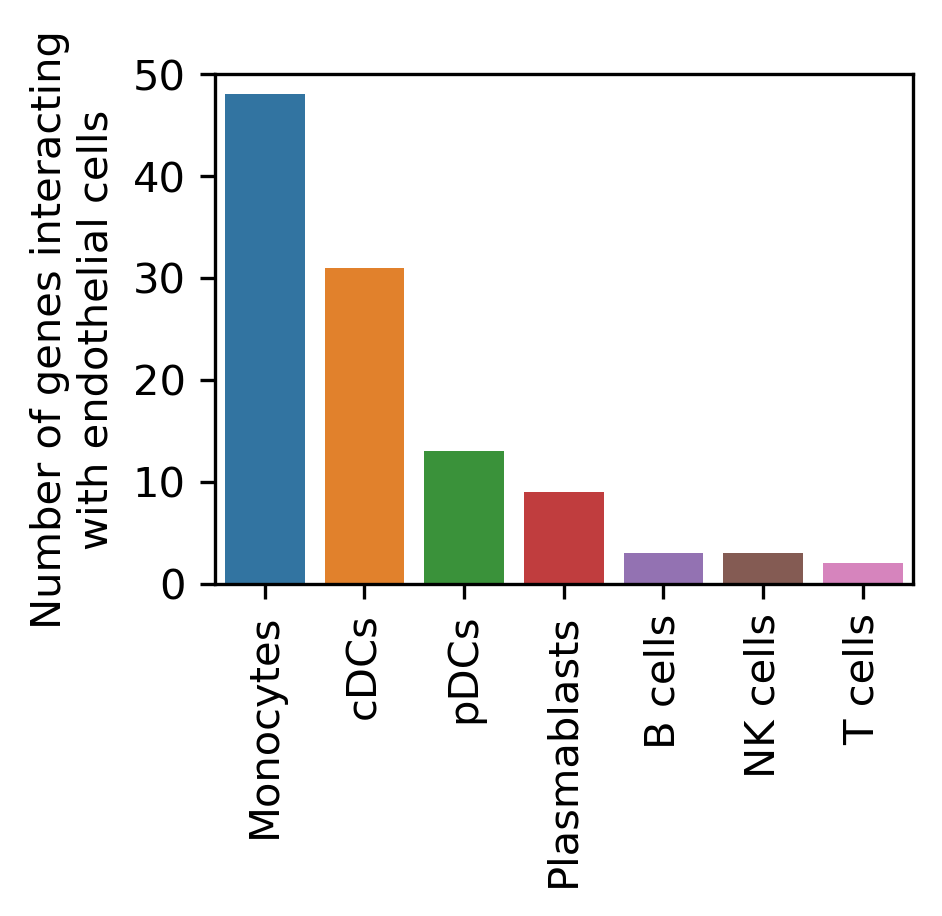

In [105]:
fig, ax = plt.subplots(figsize=[3, 2.25], dpi=300)
ax = sns.barplot(data=sig_it_n, x='Cell type', y='Number of interactions')
ax.set_xticklabels([ct.replace('_', ' ') for ct in sig_it_n['Cell type'].tolist()], rotation=90)
ax.set_ylim(0, 50)
ax.set_xlabel(None)
ax.set_ylabel('Number of genes interacting\nwith endothelial cells')

In [86]:
DEIs

ga         gb  med_pair  fra_pair     S_fra    NS_fra  \
cta                                                                     
B_cells       AREG       EGFR -1.192229  0.078125  0.086469  0.227494   
B_cells      CXCR4     CXCL12 -2.344767  0.078125  0.346177  0.578619   
B_cells       AREG      ICAM1 -1.192229  0.078125  0.086469  0.227494   
Monocytes      MIF       EGFR -1.105446  0.234375  0.582525  0.706522   
Monocytes  TNFSF10  TNFRSF10A  3.292566  0.796875  0.686873  0.325181   
...            ...        ...       ...       ...       ...       ...   
pDCs       TNFSF10  TNFRSF10D  1.462609  0.796875  0.262643  0.042105   
pDCs           SCT      VIPR1 -1.601320  0.125000  0.621533  0.778947   
pDCs         PLAUR      ITGAV -1.713288  0.171875  0.145188  0.336842   
pDCs         PLAUR      ITGB3 -1.713288  0.171875  0.145188  0.336842   
pDCs         PLAUR      ITGB1 -1.713288  0.171875  0.145188  0.336842   

                S_avg      NS_avg  statistic         pvalue      avg1  \
cta                                                                     
B_cells      0.763492    3.173555   0.141025   8.585074e-77  2.061277   
B_cells      8.860322   42.885930   0.232743  5.009162e-210  5.455697   
B_cells      0.763492    3.173555   0.141025   8.585074e-77  2.061277   
Monocytes   36.835390   80.297440   0.126380   1.554626e-14  6.345137   
Monocytes  120.487335    5.844848   0.428358  5.855526e-169  2.775018   
...               ...         ...        ...            ...       ...   
pDCs         3.873009    0.254449   0.220537   5.359774e-04  0.327053   
pDCs        55.600166  169.176640   0.179394   8.618278e-03  7.410889   
pDCs         1.274154    5.631422   0.196548   2.906031e-03  2.729318   
pDCs         1.274154    5.631422   0.196548   2.906031e-03  2.729318   
pDCs         1.274154    5.631422   0.196548   2.906031e-03  2.729318   

               avg2  log2_fold_change  endo_fra    endo_avg inter_type  
cta                                                                     
B_cells    0.818435         -1.242842  0.119937   54.142517       down  
B_cells    3.301632         -2.154065  0.325733  153.107860       down  
B_cells    0.818435         -1.242842  0.581976  279.744870       down  
Monocytes  5.241652         -1.103485  0.119937   54.142517       down  
Monocytes  6.924661          4.149644  0.271611  128.982130         up  
...             ...               ...       ...         ...        ...  
pDCs       2.284813          1.957760  0.404995  192.571490         up  
pDCs       5.822735         -1.588154  0.156686   92.141750       down  
pDCs       1.185330         -1.543988  0.302848  130.350430       down  
pDCs       1.185330         -1.543988  0.035413   17.377260       down  
pDCs       1.185330         -1.543988  0.818341  386.632020       down  

[109 rows x 16 columns]

# select significant interactions

In [89]:
im_ed = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/sick_Healthy/im_ed_ave002.tsv',
                           sep='\t', index_col=['condition', 'cta', 'ga', 'gb'])

im_ed_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/sick_Healthy/im_ed_cst002.tsv',
                           sep='\t', index_col=['condition', 'cta', 'ga', 'gb', 'ctb'])

In [90]:
im_ed_s = im_ed.loc['sick'].loc[cts]
im_ed_H = im_ed.loc['Healthy'].loc[cts]

im_ed_cst_s = im_ed_cst.loc['sick']
im_ed_cst_H = im_ed_cst.loc['Healthy']

im_ed_sick_only = list(set(list(im_ed_s.index)) - set(list(im_ed_H.index)))
im_ed_Healthy_only = list(set(list(im_ed_H.index)) - set(list(im_ed_s.index))) 

In [182]:
def inter_in_ct(inters, ylim, title):    
    it = defaultdict(list)
    for (cta, ga, gb) in inters:
        for ct in cts:
            if ct == cta:
                it[ct].append((cta, ga, gb))

    it_n = {ct: len(it[ct]) for ct in cts}  

    n = pd.DataFrame(it_n.values(), columns=['Number of interactions'])
    n['Cell type'] = [ct.replace('_', ' ') for ct in it_n.keys()]  
    n.sort_values('Number of interactions', ascending=False, inplace=True)

    fig, ax = plt.subplots(figsize=[3, 2.25], dpi=300)
    ax = sns.barplot(data=n, x='Cell type', y='Number of interactions')
    ax.set_xticklabels([ct.replace('_', ' ') for ct in n['Cell type'].tolist()], rotation=90)
    ax.set_ylim(0, ylim)
    ax.set_xlabel(None)
    ax.set_ylabel('Number of interactions')
    ax.set_title('%s specific'%title)
    return {'figure': fig, 'ax': ax}

In [91]:
im_ed_sick = im_ed_s.loc[im_ed_sick_only]
im_ed_Healthy = im_ed_H.loc[im_ed_Healthy_only]

{'figure': <Figure size 900x675 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Sick specific'}, ylabel='Number of interactions'>}

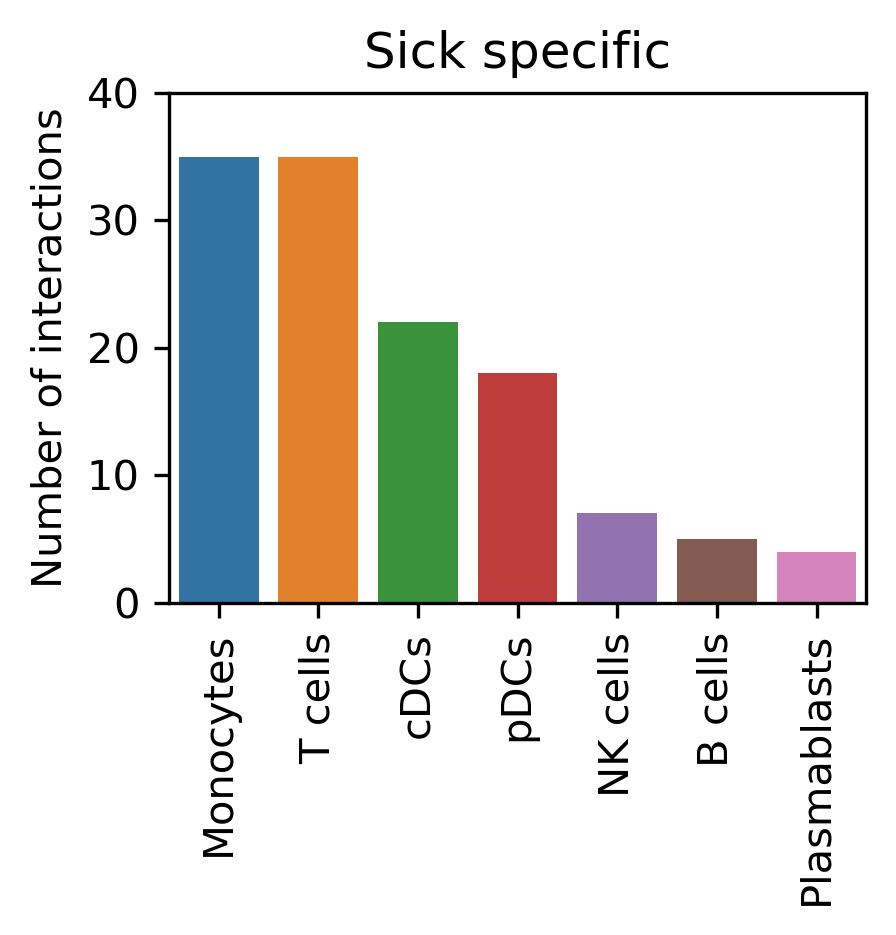

In [183]:
inter_in_ct(im_ed_sick_only, 40, 'Sick')

{'figure': <Figure size 900x675 with 1 Axes>,
 'ax': <AxesSubplot:title={'center':'Healthy specific'}, ylabel='Number of interactions'>}

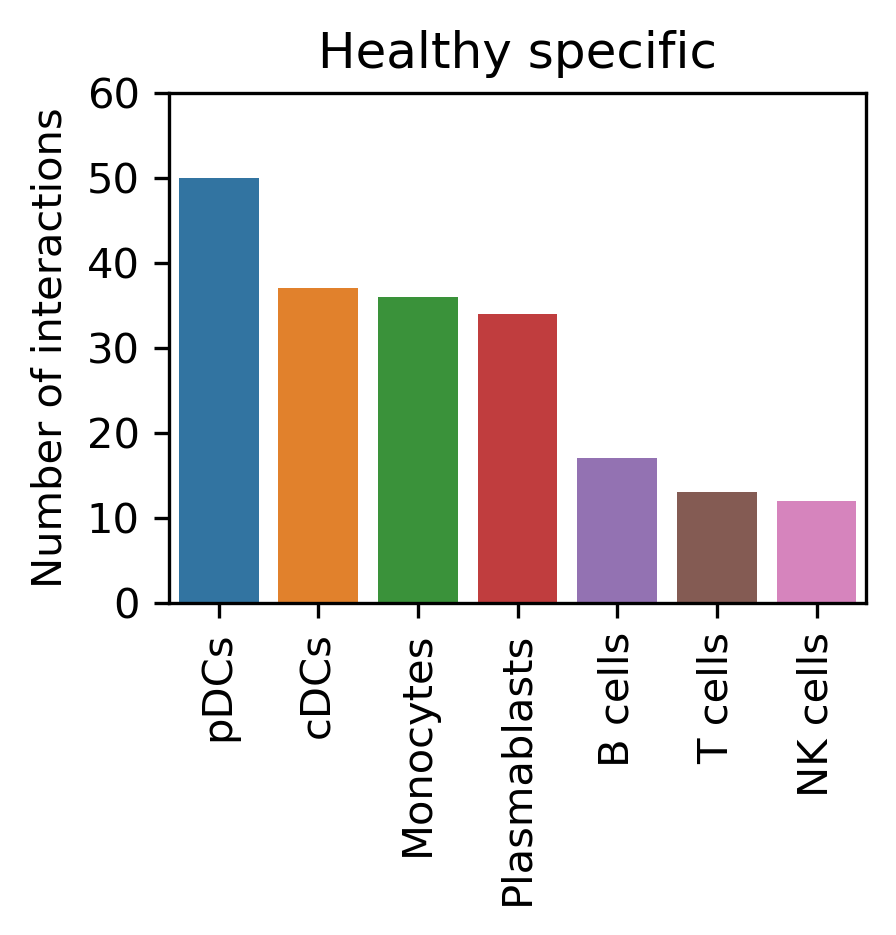

In [184]:
inter_in_ct(im_ed_Healthy_only, 60, 'Healthy')

In [137]:
inters_im = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/sick_Healthy/im_ed_cst002.tsv', sep='\t', 
                        index_col=['cta', 'ctb', 'condition'])
inters_im = inters_im.loc[cts]

# im_ed_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/sick_Healthy/im_ed_cst002.tsv',
#                            sep='\t', index_col=['condition', 'cta', 'ga', 'gb', 'ctb'])
intern_im = {}
for key in inters_im.index:
    intern_im[key] = inters_im.loc[key].shape[0]
    
colors_im = {}
norm_intern_im = {}
vmin, vmax = 0, 350

for key in intern_im.keys():
    norm_intern_im[key] = (min(intern_im[(key)], vmax) - vmin)/(vmax - vmin)
    colors_im[key] = plt.cm.get_cmap('plasma')(norm_intern_im[key])
#######################################################################
print('get the heatmap showing the number of interactions at SD and D')
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

# cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

for cst1 in cts:
    for cst2 in ['Lymphatic ECs', 'Capillary ECs', 'Venous ECs', 'Arterial ECs']:
        ls_im[cst1].append(intern_im[(cst1, cst2, 'sick')])
    it_im[cst1] = ls_im[cst1]
    
it_im.index = pd.Index(['Lymphatic ECs', 'Capillary ECs', 'Venous ECs', 'Arterial ECs'])  

from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 

it_im_new = it_im.iloc[best_order_im]
cts_im_op = list(it_im_new.index)

distance = pdist(it_im_new.T.values) 
lkg = linkage(distance, optimal_ordering=True)
best_order_ct = leaves_list(lkg)
cts_im = list(it_im_new.T.index[best_order_ct])

<ipython-input-137-9907502425cc>:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0]


get the heatmap showing the number of interactions at SD and D


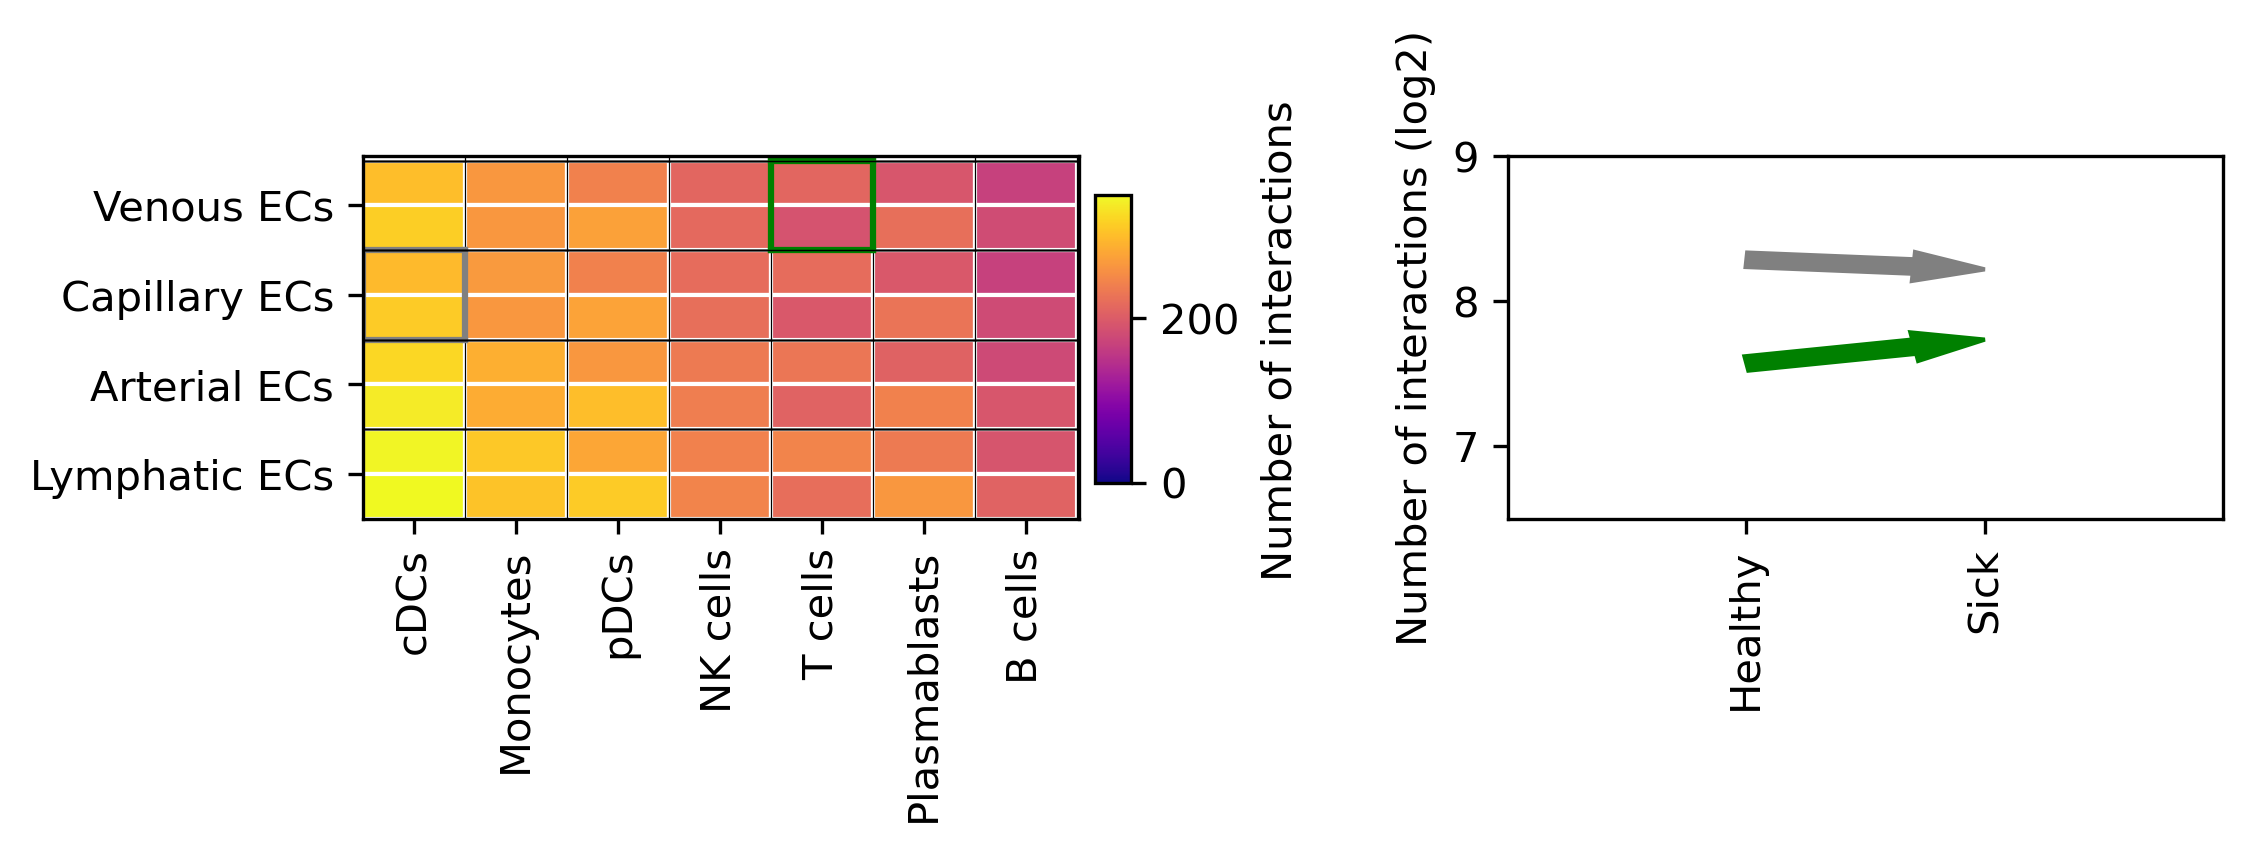

In [157]:
fig, axs = plt.subplots(1, 2, figsize=[8, 1.6], dpi=300) 
plt.subplots_adjust(wspace=0.6)

###############################
for a in range(len(cts_im)):
    axs[0].axvline(a+1, c='black', lw=0.3)
    for b in range(len(cts_im_op)):
        axs[0].axhline(b+1, c='black', lw=0.3)
        
#         if a+b <= len(cts_im_op) - 1:
        dots1 = [[a, b+0.5],
                [a+1, b+0.5],
                [a+1, b+1],
                [a, b+1],
        ]
        e1 = mpatches.Polygon(np.array(dots1), facecolor=colors_im[(cts_im[a], cts_im_op[b], 'sick')],
                              edgecolor='white')
        axs[0].add_patch(e1)

        dots2 = [[a, b],
                [a+1, b],
                [a+1, b+0.5],
                [a, b+0.5],
        ]
        e2 = mpatches.Polygon(np.array(dots2), facecolor=colors_im[(cts_im[a], cts_im_op[b], 'Healthy')], 
                              edgecolor='white')
        axs[0].add_patch(e2)

        if (cts_im[a], cts_im_op[b]) == ('T_cells', 'Venous ECs'):
            axs[0].plot([a, a+1], [b, b], color='green')
            axs[0].plot([a+1, a+1], [b, b+1], color='green')
            axs[0].plot([a, a+1], [b+1, b+1], color='green')
            axs[0].plot([a, a], [b, b+1], color='green')

        elif (cts_im[a], cts_im_op[b]) == ('cDCs', 'Capillary ECs'):
            axs[0].plot([a, a+1], [b, b], color='gray')
            axs[0].plot([a+1, a+1], [b, b+1], color='gray')
            axs[0].plot([a, a+1], [b+1, b+1], color='gray')
            axs[0].plot([a, a], [b, b+1], color='gray')

axs[0].set_xlim([0, len(cts_im) + 0.02])
axs[0].set_ylim([0, len(cts_im_op) + 0.05])
axs[0].set_xticks([i + 0.5 for i in range(len(cts_im))])
axs[0].set_yticks([i + 0.5 for i in range(len(cts_im_op))])

labels = [i.replace('_', ' ') for i in cts_im]
axs[0].set_xticklabels(labels, rotation=90)
axs[0].set_yticklabels(cts_im_op)

#vmin, vmax = 0, 350
norm_im = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_im = plt.cm.get_cmap('plasma')
position_im = fig.add_axes([0.43, 0.2, 0.015, 0.6])
cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), cax=position_im, ax=axs[0], fraction=0.01, pad=0.01, orientation='vertical')

axs[0].text(len(cts_im_op) + 4.8, 2, 'Number of interactions', verticalalignment='center', rotation=90)

##################################
y_green = [np.log2(intern_im['T_cells', 'Venous ECs', 'Healthy']), 
          np.log2(intern_im['T_cells', 'Venous ECs', 'sick'])]

y_gray = [np.log2(intern_im['cDCs', 'Capillary ECs', 'Healthy']), 
          np.log2(intern_im['cDCs', 'Capillary ECs', 'sick'])]


axs[1].arrow(1, y_green[0], 1, y_green[1] - y_green[0], length_includes_head=True, color='green', width=0.1, head_width=0.2)
axs[1].arrow(1, y_gray[0], 1, y_gray[1] - y_gray[0], length_includes_head=True, color='gray', width=0.1, head_width=0.2) 

axs[1].set_xlim(0, 3)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Healthy', 'Sick'], rotation=90)
axs[1].set_ylim(6.5, 9)
axs[1].set_ylabel('Number of interactions (log2)')

plt.show()

In [169]:
np.unique(im_ed_sick.reset_index()[['ga', 'gb']])

array(['ACKR1', 'ACVR1B', 'ADGRG5', 'ADORA2B', 'ADRB2', 'ARF1', 'AXL',
       'BMP2', 'BMP4', 'BMP6', 'BMPR1A', 'BMPR2', 'C5', 'C5AR1', 'CADM1',
       'CCL14', 'CCL2', 'CCL23', 'CCL28', 'CCL8', 'CCR1', 'CCR10', 'CCR2',
       'CCR5', 'CD274', 'CD40', 'CD70', 'CMKLR1', 'COPA', 'CRTAM', 'CSF1',
       'CSF3', 'CSF3R', 'CXCL10', 'CXCL12', 'CXCL16', 'CXCR3', 'CXCR6',
       'DLL1', 'DLL4', 'DPP4', 'DSC2', 'DSG2', 'EFNB1', 'EFNB2', 'ENTPD1',
       'EPHB1', 'EPHB2', 'EPOR', 'FAM3C', 'FAS', 'FBN1', 'FLT1', 'FLT3',
       'FLT3LG', 'FN1', 'GAS6', 'GDF11', 'GHRL', 'GPRC5B', 'HAVCR2',
       'IDE', 'IFNG', 'IFNGR1', 'IFNGR2', 'IGF2', 'IGF2R', 'IL15',
       'IL15RA', 'IL18', 'IL18R1', 'IL27', 'IL27RA', 'IL6ST', 'INHBB',
       'ITGA10', 'ITGA2', 'ITGA3', 'ITGA5', 'ITGA8', 'ITGAV', 'ITGB1',
       'ITGB3', 'ITGB5', 'ITGB7', 'JAG1', 'JAG2', 'KDR', 'KIT', 'KITLG',
       'LGALS9', 'LTBR', 'MERTK', 'NAMPT', 'NOTCH1', 'NOTCH2', 'NRP1',
       'P2RY6', 'PDCD1', 'PDCD1LG2', 'PDGFB', 'PDGFD', 'PDGFRB'

In [173]:
np.unique(im_ed_Healthy.reset_index()[['ga', 'gb']])

array(['ACKR1', 'ACVR1', 'ACVR1B', 'ACVR2A', 'ACVR2B', 'ADORA1', 'ALCAM',
       'ANXA1', 'AREG', 'ARF1', 'BAG6', 'BMP2', 'BMP4', 'BMP6', 'BMPR1A',
       'BMPR2', 'CCL3L1', 'CCL4L2', 'CD160', 'CD2', 'CD200', 'CD200R1',
       'CD274', 'CD46', 'CD47', 'CD58', 'CD6', 'CD80', 'CD96', 'CLCF1',
       'CLEC2B', 'CLEC2D', 'COL18A1', 'COL19A1', 'COL4A3', 'CXCL1',
       'CXCL2', 'CXCL8', 'DAG1', 'DLL1', 'DLL4', 'DPP4', 'DSC2', 'DSG2',
       'EBI3', 'EFNA1', 'EFNA2', 'EFNA4', 'EFNB1', 'EFNB2', 'ENTPD1',
       'EPHA2', 'EPHA4', 'EPHA7', 'EPHB4', 'EPHB6', 'EPOR', 'FAM3B',
       'FAS', 'FCER2', 'FGF2', 'FGFR3', 'FLT1', 'FLT4', 'FN1', 'FPR3',
       'GDF11', 'HEBP1', 'HRH1', 'ICAM1', 'IL15', 'IL1A', 'IL1R1',
       'IL1R2', 'IL1RAP', 'IL27RA', 'IL2RB', 'IL6', 'IL6R', 'IL6ST',
       'IL7R', 'INHBA', 'INHBB', 'ITGA1', 'ITGA10', 'ITGA2', 'ITGAM',
       'ITGAV', 'ITGB1', 'ITGB3', 'JAG1', 'JAG2', 'JAM3', 'KDR', 'KITLG',
       'KLRB1', 'KLRF1', 'LAMC1', 'LGALS9', 'LIFR', 'LRP5', 'MDK', 'MMP2',
  

In [96]:
# 'Monocytes', 'T_cells', 'cDCs', 'pDCs'
im_ed_sick.loc['B_cells']

im_fra    im_avg  endo_fra    endo_avg
ga     gb                                              
SELPLG SELL    0.020846  0.135688  0.022801   10.185828
CXCR3  CXCL12  0.039509  0.270998  0.325733  153.107864
SELPLG SELE    0.020846  0.135688  0.323394  158.401871
FAS    TNF     0.027544  0.177584  0.025140   14.603204
SELPLG SELP    0.020846  0.135688  0.367911  176.965225

In [171]:
im_ed_sick.loc['NK_cells']

im_fra    im_avg  endo_fra    endo_avg
ga     gb                                              
SLC1A5 LGALS9  0.050565  0.344991  0.151173   64.488503
PDGFRB PDGFB   0.030226  0.200470  0.251065  129.946625
CCR1   CCL8    0.030273  0.196232  0.021381   11.183074
IL18   IL18R1  0.020151  0.127364  0.138645   70.968002
CCR1   CCL23   0.030273  0.196232  0.143740   69.019562
PDGFRB PDGFD   0.030226  0.200470  0.070408   30.126461
CCR1   CCL14   0.030273  0.196232  0.359392  171.779053

In [172]:
im_ed_sick.loc['Plasmablasts']

im_fra    im_avg  endo_fra    endo_avg
ga       gb                                             
TNFSF13B TFRC   0.024326  0.143167  0.146496   59.671127
ADRB2    VEGFB  0.024966  0.132834  0.124113   45.258305
TNFSF13B CD40   0.024326  0.143167  0.286979  127.366592
EPOR     KITLG  0.022761  0.111017  0.291072  128.347885

In [164]:
a = im_ed_sick.loc['Monocytes']
np.unique(a.reset_index()[['ga', 'gb']])

array(['ACKR1', 'ACVR1B', 'BMP2', 'BMP4', 'BMP6', 'BMPR1A', 'BMPR2',
       'CCL2', 'CCL8', 'CCR5', 'CMKLR1', 'COPA', 'CXCL10', 'DPP4', 'DSC2',
       'DSG2', 'EFNB1', 'EFNB2', 'EPHB2', 'FLT3', 'FLT3LG', 'FN1', 'GAS6',
       'GDF11', 'IL27', 'IL27RA', 'IL6ST', 'INHBB', 'ITGA10', 'ITGA2',
       'ITGA3', 'ITGA5', 'ITGA8', 'ITGAV', 'ITGB1', 'ITGB3', 'ITGB5',
       'ITGB7', 'MERTK', 'NAMPT', 'P2RY6', 'RARRES2', 'TNFRSF10A',
       'TNFSF10', 'TYRO3', 'VCAM1', 'VEGFA'], dtype=object)

In [165]:
b = im_ed_sick.loc['T_cells']
np.unique(b.reset_index()[['ga', 'gb']])

array(['ADGRG5', 'CCL14', 'CCL2', 'CCL23', 'CCL8', 'CCR1', 'CCR2', 'CCR5',
       'CD274', 'CD40', 'CD70', 'CSF1', 'CXCL16', 'CXCR6', 'DLL1', 'DLL4',
       'FAM3C', 'GPRC5B', 'HAVCR2', 'IDE', 'IFNG', 'IFNGR1', 'IFNGR2',
       'IGF2', 'IL15', 'IL15RA', 'JAG1', 'JAG2', 'LGALS9', 'LTBR',
       'NAMPT', 'NOTCH1', 'NOTCH2', 'PDCD1', 'PDCD1LG2', 'SLC1A5',
       'SLC7A1', 'TFRC', 'TNF', 'TNFRSF14', 'TNFSF13B', 'TNFSF14',
       'TNFSF9'], dtype=object)

In [166]:
c = im_ed_sick.loc['cDCs']
np.unique(c.reset_index()[['ga', 'gb']])

array(['ADGRG5', 'ADORA2B', 'ADRB2', 'ARF1', 'C5', 'C5AR1', 'CADM1',
       'CCL14', 'CCL23', 'CCL8', 'CCR1', 'CRTAM', 'CXCL10', 'DPP4',
       'EFNB1', 'EFNB2', 'ENTPD1', 'EPHB1', 'FAM3C', 'FLT1', 'IGF2',
       'IGF2R', 'KDR', 'KIT', 'KITLG', 'NRP1', 'PGF', 'PLD2', 'SEMA3A',
       'TNFSF9', 'VEGFA', 'VEGFB'], dtype=object)

In [167]:
d = im_ed_sick.loc['pDCs']
np.unique(d.reset_index()[['ga', 'gb']])

array(['AXL', 'CCL2', 'CCL28', 'CCL8', 'CCR10', 'CCR5', 'CSF1', 'CSF3',
       'CSF3R', 'FAS', 'FBN1', 'FN1', 'GAS6', 'GHRL', 'HAVCR2', 'IL15RA',
       'ITGA5', 'LGALS9', 'NAMPT', 'PLXNC1', 'PLXND1', 'PROS1', 'SEMA3E',
       'SEMA4A', 'SEMA7A', 'SLC7A1', 'TBXA2R', 'TNF', 'TNFRSF8', 'TNFSF8'],
      dtype=object)

# intersection of DEIs and im_ed_sick

In [94]:
intersec = list(set(list(DEIs.set_index([DEIs.index, 'ga', 'gb']).index)) & set(list(im_ed_sick.index)))

In [95]:
intersec

[('cDCs', 'CCR1', 'CCL14'),
 ('Monocytes', 'CXCL10', 'DPP4'),
 ('cDCs', 'CCR1', 'CCL8'),
 ('cDCs', 'CCR1', 'CCL23')]

# get heatmap plot showing number of interactions in distinct immune cell types and endothelial cell subtypes

In [251]:
def inter_number(inters_df, cts, vmax, inter_type):
    it_n = inters_df.groupby(['cta', 'ctb']).size().unstack(fill_value=0)
    idx_ap = list(set(cts) - set(it_n.index.tolist()))
    for idx in idx_ap:
        it_n.loc[idx] = [0] * it_n.shape[1]

    from scipy.spatial.distance import pdist
    from scipy.cluster.hierarchy import linkage, leaves_list
    import matplotlib.patches as mpatches

    lkg_idx = linkage(pdist(it_n.values), optimal_ordering=True)
    best_idx = leaves_list(lkg_idx)

    it_n = it_n.iloc[best_idx]
    it_n = it_n[['Lymphatic ECs', 'Venous ECs', 'Arterial ECs', 'Capillary ECs']]
#     lkg_col = linkage(pdist(it_n.T.values), optimal_ordering=True)
#     best_col = leaves_list(lkg_col)
#     best_col = it_n.columns[best_col]
#     it_n = it_n[best_col]

    fig, ax = plt.subplots(figsize=[3 * it_n.shape[0]/7, 1.5], dpi=300)
    sns.heatmap(it_n.T, ax=ax, cmap='plasma', linecolor='w', linewidths=1, vmin=0, vmax=vmax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    ax.axvline(0, c='black')
    ax.axhline(0, c='black')

    ax.axvline(7, c='black')
    ax.axhline(7, c='black')

    xlabels = [i.get_text().replace('_', ' ') for i in ax.get_xticklabels()]
    ax.set_xticklabels(xlabels)

    ax.text(len(cts) + 2.3, 2, 'Number of interactions', verticalalignment='center', rotation=90)
    ax.set_title('%sregulated'%inter_type)
    
    return {'figure': fig, 'ax': ax}

{'figure': <Figure size 900x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'upregulated'}>}

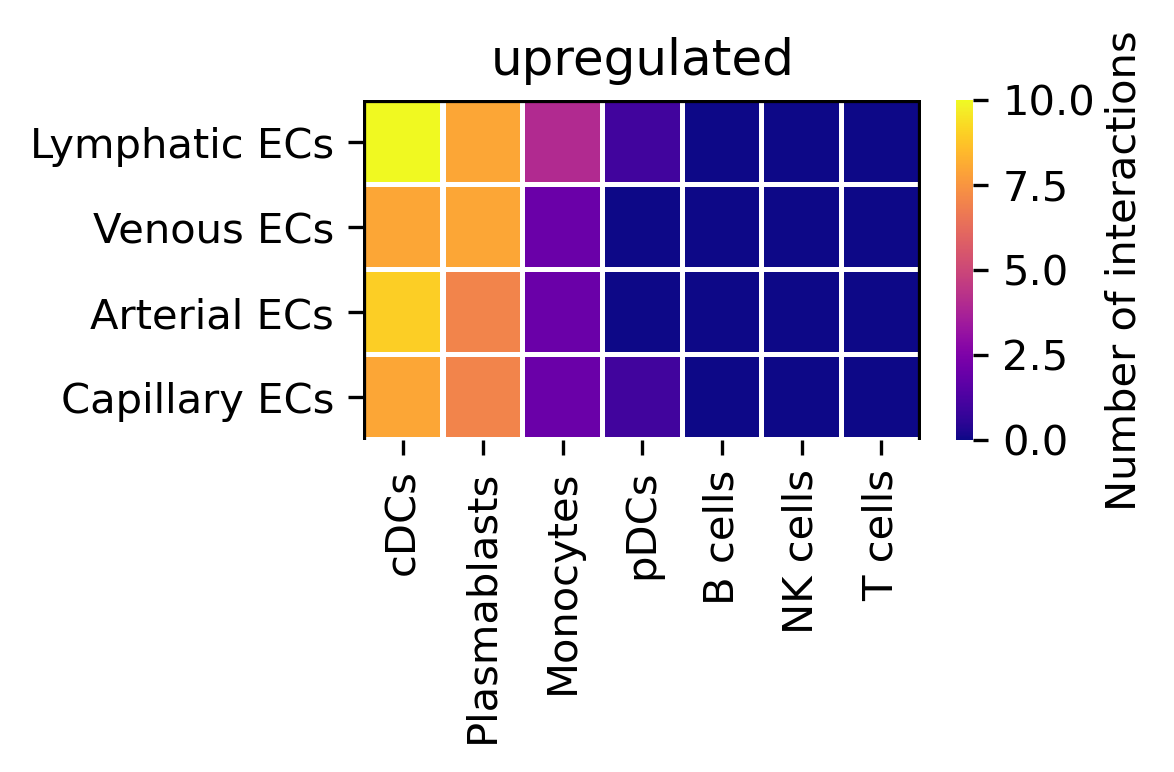

In [252]:
# heatmap plot showing the number of upregulated interactions
inter_number(im_ed_cst[im_ed_cst['inter_type'] == 'up'], cts, 10, 'up')

{'figure': <Figure size 900x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'downregulated'}>}

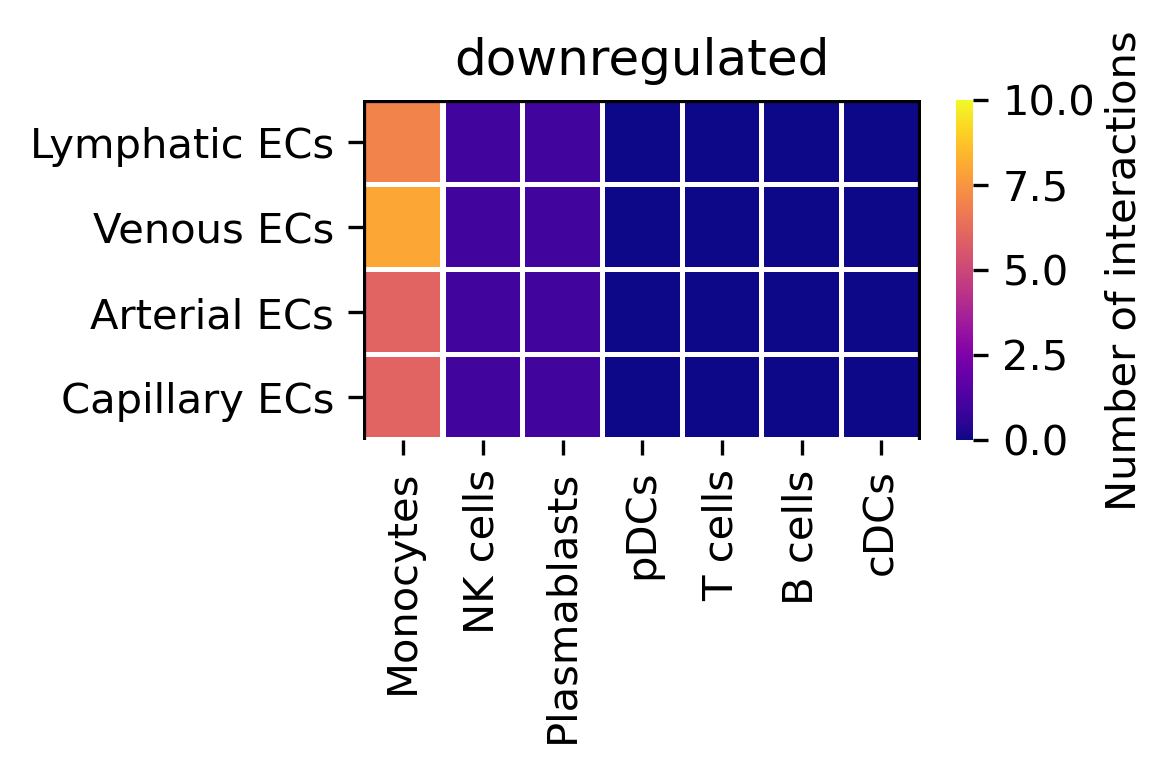

In [253]:
# heatmap plot showing the number of downregulated interactions
inter_number(im_ed_cst[im_ed_cst['inter_type'] == 'down'], cts, 10, 'down')

{'figure': <Figure size 385.714x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'upregulated'}>}

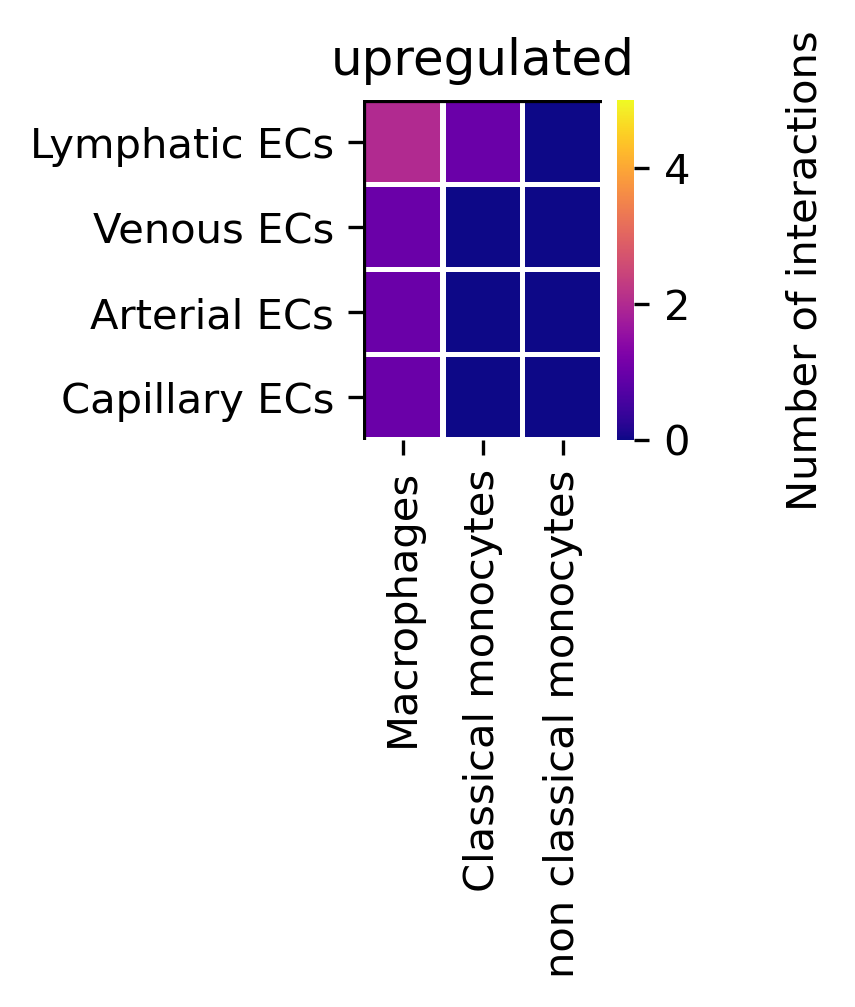

In [254]:
# heatmap plot showing the number of upregulated interactions

csts_n = ['Classical_monocytes', 'Macrophages', 'non_classical_monocytes']
inter_number(im_cst_ed_cst[im_cst_ed_cst['inter_type'] == 'up'].loc[csts_n], csts_n, 5, 'up')

{'figure': <Figure size 385.714x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'downregulated'}>}

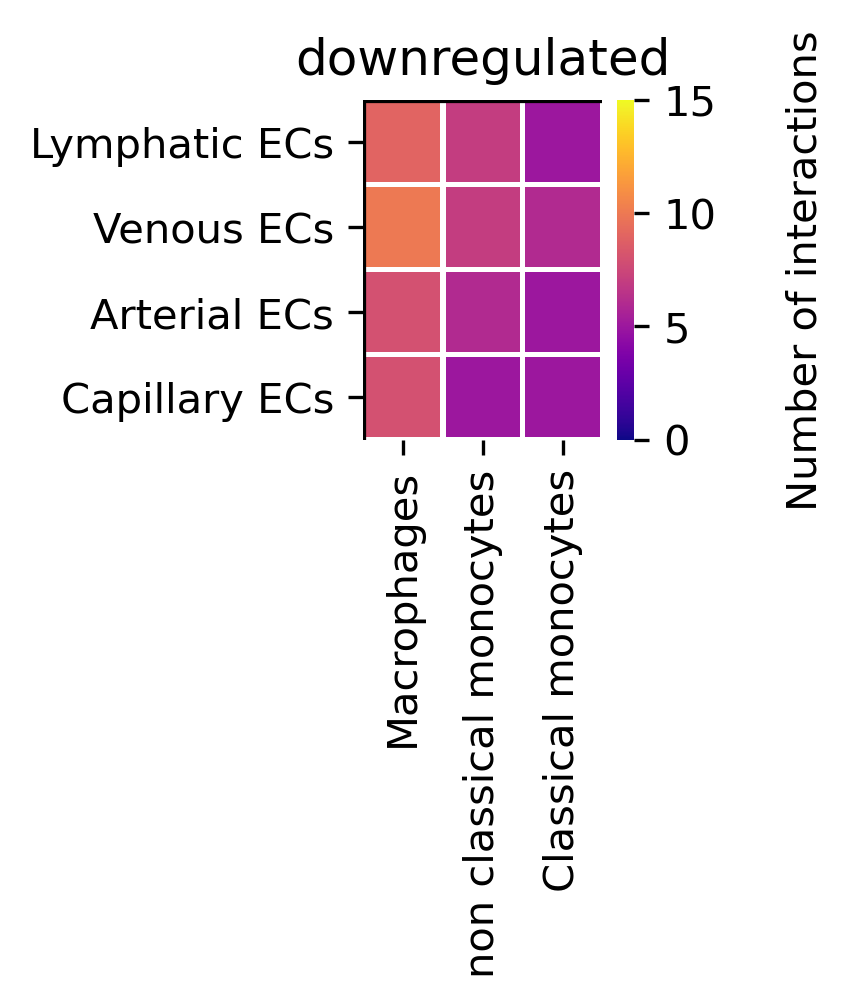

In [255]:
# heatmap plot showing the number of downregulated interactions

csts_n = ['Classical_monocytes', 'Macrophages', 'non_classical_monocytes']
inter_number(im_cst_ed_cst[im_cst_ed_cst['inter_type'] == 'down'].loc[csts_n], csts_n, 15, 'down')

{'figure': <Figure size 642.857x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'upregulated'}>}

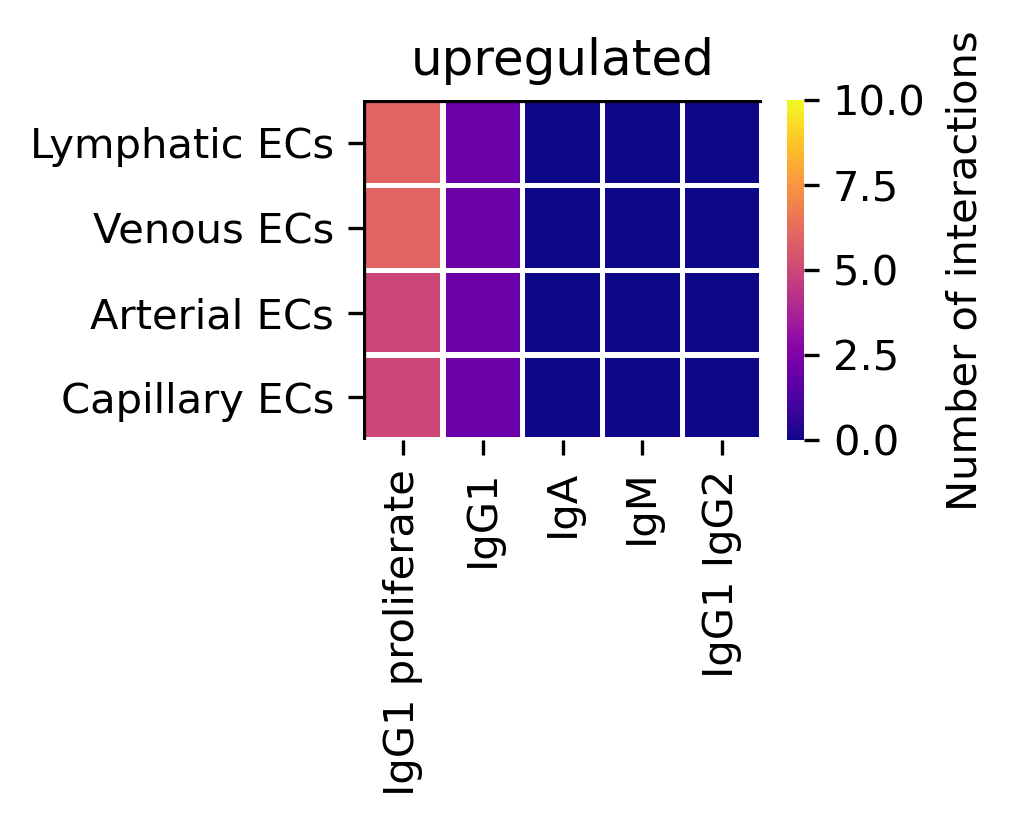

In [256]:
# heatmap plot showing the number of upregulated interactions

csts_n = ['IgA', 'IgG1', 'IgG1_IgG2', 'IgG1_proliferate', 'IgM']
inter_number(im_cst_ed_cst[im_cst_ed_cst['inter_type'] == 'up'].loc[csts_n], csts_n, 10, 'up')

{'figure': <Figure size 385.714x450 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'upregulated'}>}

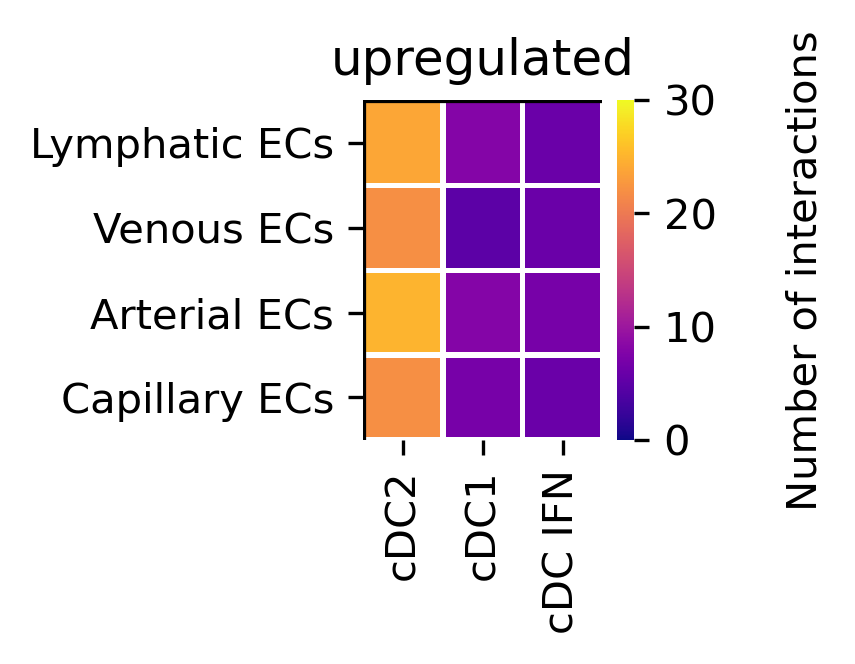

In [257]:
# heatmap plot showing the number of upregulated interactions

csts_n = ['cDC1', 'cDC2', 'cDC_IFN']
inter_number(im_cst_ed_cst[im_cst_ed_cst['inter_type'] == 'up'].loc[csts_n], csts_n, 30, 'up')

In [96]:
im_ed

med_pair  fra_pair     S_fra    NS_fra  \
cta          ga      gb                                                  
Monocytes    EREG    EGFR       1.554128  0.781250  0.181419  0.024549   
             TNFSF10 TNFRSF10A -1.538971  0.093750  0.527614  0.768953   
             CX3CR1  CX3CL1    -1.817206  0.062500  0.090180  0.209386   
             TNFSF10 TNFRSF11B -1.538971  0.093750  0.527614  0.768953   
                     RIPK1     -1.538971  0.093750  0.527614  0.768953   
             CXCL10  DPP4      -3.201429  0.156250  0.043880  0.235379   
             TNFSF10 TNFRSF10B -1.538971  0.093750  0.527614  0.768953   
             CXCL8   ACKR1      1.179383  0.781250  0.550310  0.224549   
             TNFSF10 TNFRSF10D -1.538971  0.093750  0.527614  0.768953   
NK_cells     CD160   TNFRSF14  -1.428393  0.187500  0.189044  0.357367   
Plasmablasts GAS6    MERTK      2.085610  0.968750  0.183198  0.026664   
             LAMP1   FAM3C      1.342261  0.875000  0.218929  0.059275   
             LTB     LTBR      -1.725172  0.156250  0.029278  0.146557   
             GAS6    TYRO3      2.085610  0.968750  0.183198  0.026664   
             CCR2    CCL2       1.432915  0.875000  0.298996  0.139075   
                     CCL8       1.432915  0.875000  0.298996  0.139075   
             IL6ST   IL6        1.086855  0.968750  0.225143  0.080184   
                     CLCF1      1.086855  0.968750  0.225143  0.080184   
cDCs         FLT3    FLT3LG     1.181828  0.958333  0.459227  0.238938   
             SLC1A5  LGALS9     6.209186  0.958333  0.296137  0.088496   
             ITGB2   VCAM1      1.051861  0.916667  0.944206  0.716814   
                     ICAM2      1.051861  0.916667  0.944206  0.716814   
                     F11R       1.051861  0.916667  0.944206  0.716814   
                     ICAM4      1.051861  0.916667  0.944206  0.716814   
                     ICAM1      1.051861  0.916667  0.944206  0.716814   
                     JAM3       1.051861  0.916667  0.944206  0.716814   
pDCs         VSIR    TNF        1.549537  0.875000  0.307359  0.141935   

                                     S_avg       NS_avg  statistic  \
cta          ga      gb                                              
Monocytes    EREG    EGFR       114.229919    15.239890   0.156871   
             TNFSF10 TNFRSF10A  340.174530  1228.641846   0.408387   
             CX3CR1  CX3CL1      29.787165   118.979347   0.136732   
             TNFSF10 TNFRSF11B  340.174530  1228.641846   0.408387   
                     RIPK1      340.174530  1228.641846   0.408387   
             CXCL10  DPP4        50.618126   643.338806   0.195957   
             TNFSF10 TNFRSF10B  340.174530  1228.641846   0.408387   
             CXCL8   ACKR1      645.129150   163.494156   0.325761   
             TNFSF10 TNFRSF10D  340.174530  1228.641846   0.408387   
NK_cells     CD160   TNFRSF14   136.020966   314.062622   0.178518   
Plasmablasts GAS6    MERTK       36.555595     5.846004   0.156726   
             LAMP1   FAM3C       33.886395    13.219375   0.159654   
             LTB     LTBR        11.833469    71.511162   0.122842   
             GAS6    TYRO3       36.555595     5.846004   0.156726   
             CCR2    CCL2        72.539970    42.910378   0.159921   
                     CCL8        72.539970    42.910378   0.159921   
             IL6ST   IL6         58.934650    21.996387   0.145151   
                     CLCF1       58.934650    21.996387   0.145151   
cDCs         FLT3    FLT3LG     105.569130    57.086494   0.211062   
             SLC1A5  LGALS9      54.837688    21.338099   0.207338   
             ITGB2   VCAM1      895.863159   515.343811   0.372603   
                     ICAM2      895.863159   515.343811   0.372603   
                     F11R       895.863159   515.343811   0.372603   
                     ICAM4      895.863159   515.343811   0.372603   
                     ICAM1      895.863159   515.343811   0.37260

In [114]:
im_ed_cst[: 60]

med_pair  fra_pair     S_fra  \
cta          ga      gb        ctb                                           
Monocytes    EREG    EGFR      Arterial ECs   1.554128   0.78125  0.181419   
                               Capillary ECs  1.554128   0.78125  0.181419   
                               Lymphatic ECs  1.554128   0.78125  0.181419   
                               Venous ECs     1.554128   0.78125  0.181419   
             TNFSF10 TNFRSF10A Arterial ECs  -1.538971   0.09375  0.527614   
                               Capillary ECs -1.538971   0.09375  0.527614   
                               Lymphatic ECs -1.538971   0.09375  0.527614   
                               Venous ECs    -1.538971   0.09375  0.527614   
             CX3CR1  CX3CL1    Arterial ECs  -1.817206   0.06250  0.090180   
                               Capillary ECs -1.817206   0.06250  0.090180   
                               Lymphatic ECs -1.817206   0.06250  0.090180   
                               Venous ECs    -1.817206   0.06250  0.090180   
             ALOX5AP ALOX5     Lymphatic ECs  1.618942   1.00000  0.275685   
             TNFSF10 TNFRSF11B Arterial ECs  -1.538971   0.09375  0.527614   
                               Capillary ECs -1.538971   0.09375  0.527614   
                               Venous ECs    -1.538971   0.09375  0.527614   
                     RIPK1     Arterial ECs  -1.538971   0.09375  0.527614   
                               Capillary ECs -1.538971   0.09375  0.527614   
                               Lymphatic ECs -1.538971   0.09375  0.527614   
                               Venous ECs    -1.538971   0.09375  0.527614   
             EREG    ERBB4     Lymphatic ECs  1.554128   0.78125  0.181419   
             CXCL10  DPP4      Lymphatic ECs -3.201429   0.15625  0.043880   
                               Venous ECs    -3.201429   0.15625  0.043880   
             TNFSF10 TNFRSF10C Lymphatic ECs -1.538971   0.09375  0.527614   
                               Venous ECs    -1.538971   0.09375  0.527614   
                     TNFRSF10B Arterial ECs  -1.538971   0.09375  0.527614   
                               Capillary ECs -1.538971   0.09375  0.527614   
                               Lymphatic ECs -1.538971   0.09375  0.527614   
                               Venous ECs    -1.538971   0.09375  0.527614   
             CXCL8   ACKR1     Arterial ECs   1.179383   0.78125  0.550310   
                               Capillary ECs  1.179383   0.78125  0.550310   
                               Lymphatic ECs  1.179383   0.78125  0.550310   
                               Venous ECs     1.179383   0.78125  0.550310   
             TNFSF10 TNFRSF10D Arterial ECs  -1.538971   0.09375  0.527614   
                               Capillary ECs -1.538971   0.09375  0.527614   
                               Lymphatic ECs -1.538971   0.09375  0.527614   
                               Venous ECs    -1.538971   0.09375  0.527614   
NK_cells     CD160   TNFRSF14  Arterial ECs  -1.428393   0.18750  0.189044   
                               Capillary ECs -1.428393   0.18750  0.189044   
                               Lymphatic ECs -1.428393   0.18750  0.189044   
                               Venous ECs    -1.428393   0.18750  0.189044   
Plasmablasts GAS6    MERTK     Arterial ECs   2.085610   0.96875  0.183198   
                               Capillary ECs  2.085610   0.96875  0.183198   
                               Lymphatic ECs  2.085610   0.96875  0.183198   
                               Venous ECs     2.085610   0.96875  0.183198   
             LAMP1   FAM3C     Arterial ECs   1.342261   0.87500  0.218929   
                               Capillary ECs  1.342261   0.87500  0.218929   
                               Lymphatic ECs  1.342261   0.87500  0.218929   
                               Venous ECs     1.342261   0.87500  0.218929   
             LTB     LTBR      Arterial ECs  -1.725172   0.15625  0.

In [115]:
im_ed_cst[61:]

med_pair  fra_pair     S_fra  \
cta          ga     gb     ctb                                           
Plasmablasts CCR2   CCL16  Lymphatic ECs  1.432915  0.875000  0.298996   
                           Venous ECs     1.432915  0.875000  0.298996   
                    CCL8   Arterial ECs   1.432915  0.875000  0.298996   
                           Capillary ECs  1.432915  0.875000  0.298996   
                           Venous ECs     1.432915  0.875000  0.298996   
             IL6ST  IL6    Arterial ECs   1.086855  0.968750  0.225143   
                           Capillary ECs  1.086855  0.968750  0.225143   
                           Lymphatic ECs  1.086855  0.968750  0.225143   
                           Venous ECs     1.086855  0.968750  0.225143   
                    LIF    Lymphatic ECs  1.086855  0.968750  0.225143   
                    CLCF1  Arterial ECs   1.086855  0.968750  0.225143   
                           Capillary ECs  1.086855  0.968750  0.225143   
                           Lymphatic ECs  1.086855  0.968750  0.225143   
                           Venous ECs     1.086855  0.968750  0.225143   
cDCs         LILRB4 LAIR1  Lymphatic ECs  1.001725  0.958333  0.519313   
             FLT3   FLT3LG Arterial ECs   1.181828  0.958333  0.459227   
                           Capillary ECs  1.181828  0.958333  0.459227   
                           Lymphatic ECs  1.181828  0.958333  0.459227   
                           Venous ECs     1.181828  0.958333  0.459227   
             ALCAM  CD6    Lymphatic ECs  1.311624  0.916667  0.356223   
             SLC1A5 LGALS9 Arterial ECs   6.209186  0.958333  0.296137   
                           Capillary ECs  6.209186  0.958333  0.296137   
                           Lymphatic ECs  6.209186  0.958333  0.296137   
                           Venous ECs     6.209186  0.958333  0.296137   
             ITGB2  VCAM1  Arterial ECs   1.051861  0.916667  0.944206   
                           Capillary ECs  1.051861  0.916667  0.944206   
                           Lymphatic ECs  1.051861  0.916667  0.944206   
                           Venous ECs     1.051861  0.916667  0.944206   
                    ICAM2  Arterial ECs   1.051861  0.916667  0.944206   
                           Capillary ECs  1.051861  0.916667  0.944206   
                           Lymphatic ECs  1.051861  0.916667  0.944206   
                           Venous ECs     1.051861  0.916667  0.944206   
                    F11R   Arterial ECs   1.051861  0.916667  0.944206   
                           Capillary ECs  1.051861  0.916667  0.944206   
                           Lymphatic ECs  1.051861  0.916667  0.944206   
                           Venous ECs     1.051861  0.916667  0.944206   
                    ICAM4  Arterial ECs   1.051861  0.916667  0.944206   
                           Capillary ECs  1.051861  0.916667  0.944206   
                           Lymphatic ECs  1.051861  0.916667  0.944206   
                           Venous ECs     1.051861  0.916667  0.944206   
                    THY1   Arterial ECs   1.051861  0.916667  0.944206   
                    ICAM1  Arterial ECs   1.051861  0.916667  0.944206   
                           Capillary ECs  1.051861  0.916667  0.944206   
                           Lymphatic ECs  1.051861  0.916667  0.944206   
                           Venous ECs     1.051861  0.916667  0.944206   
                    JAM3   Arterial ECs   1.051861  0.916667  0.944206   
                           Capillary ECs  1.051861  0.916667  0.944206   
                           Lymphatic ECs  1.051861  0.916667  0.944206   
                           Venous ECs     1.051861  0.916667  0.944206   
pDCs         VSIR   TNF    Capillary ECs  1.549537  0.875000  0.307359   
                    CCL4L2 Lymphatic ECs  1.549537  0.875000  0.307359   

                                            NS_fra       S_avg      NS_avg  \
cta          ga     gb     ctb           

In [118]:
im_cst_ed_cst.loc[['Classical_monocytes', 'Macrophages', 'non_classical_monocytes']]

med_pair  fra_pair  \
cta                     ga      gb        ctb                                 
Classical_monocytes     TNFSF10 TNFRSF10A Arterial ECs  -1.173706  0.125000   
                                          Capillary ECs -1.173706  0.125000   
                                          Lymphatic ECs -1.173706  0.125000   
                                          Venous ECs    -1.173706  0.125000   
                        ALOX5AP ALOX5     Lymphatic ECs  1.105949  0.937500   
...                                                           ...       ...   
non_classical_monocytes TNFSF10 TNFRSF10D Capillary ECs -1.128998  0.142857   
                                          Lymphatic ECs -1.128998  0.142857   
                                          Venous ECs    -1.128998  0.142857   
                        MS4A4A  NRG1      Arterial ECs  -1.003962  0.214286   
                                          Lymphatic ECs -1.003962  0.214286   

                                                            S_fra    NS_fra  \
cta                     ga      gb        ctb                                 
Classical_monocytes     TNFSF10 TNFRSF10A Arterial ECs   0.506649  0.675369   
                                          Capillary ECs  0.506649  0.675369   
                                          Lymphatic ECs  0.506649  0.675369   
                                          Venous ECs     0.506649  0.675369   
                        ALOX5AP ALOX5     Lymphatic ECs  0.297593  0.087401   
...                                                           ...       ...   
non_classical_monocytes TNFSF10 TNFRSF10D Capillary ECs  0.818182  0.933862   
                                          Lymphatic ECs  0.818182  0.933862   
                                          Venous ECs     0.818182  0.933862   
                        MS4A4A  NRG1      Arterial ECs   0.290210  0.497354   
                                          Lymphatic ECs  0.290210  0.497354   

                                                              S_avg  \
cta                     ga      gb        ctb                         
Classical_monocytes     TNFSF10 TNFRSF10A Arterial ECs   316.383026   
                                          Capillary ECs  316.383026   
                                          Lymphatic ECs  316.383026   
                                          Venous ECs     316.383026   
                        ALOX5AP ALOX5     Lymphatic ECs  182.496262   
...                                                             ...   
non_classical_monocytes TNFSF10 TNFRSF10D Capillary ECs  735.029541   
                                          Lymphatic ECs  735.029541   
                                          Venous ECs     735.029541   
                        MS4A4A  NRG1      Arterial ECs   101.351395   
                                          Lymphatic ECs  101.351395   

                                                              NS_avg  \
cta                     ga      gb        ctb                          
Classical_monocytes     TNFSF10 TNFRSF10A Arterial ECs    789.484070   
                                          Capillary ECs   789.484070   
                                          Lymphatic ECs   789.484070   
                                          Venous ECs      789.484070   
                        ALOX5AP ALOX5     Lymphatic ECs    45.595631   
...                                                              ...   
non_classical_monocytes TNFSF10 TNFRSF10D Capillary ECs  2079.052002   
                                          Lymphatic ECs  2079.052002   
                                          Venous ECs     2079.052002   
                        MS4A4A  NRG1      Arterial ECs    373.502899   
                                          Lymphatic ECs   373.502899   

                                                         statistic  \
cta                     ga      gb        ctb                        


In [129]:
im_cst_ed_cst.loc[[ 'IgA', 'IgG1', 'IgG1_IgG2', 'IgG1_proliferate', 'IgM',]]

med_pair  fra_pair     S_fra  \
cta              ga       gb     ctb                                           
IgG1             SELL     CD34   Arterial ECs   1.058798  0.928571  0.543681   
                                 Capillary ECs  1.058798  0.928571  0.543681   
                                 Lymphatic ECs  1.058798  0.928571  0.543681   
                                 Venous ECs     1.058798  0.928571  0.543681   
                          PODXL  Arterial ECs   1.058798  0.928571  0.543681   
                                 Capillary ECs  1.058798  0.928571  0.543681   
                                 Lymphatic ECs  1.058798  0.928571  0.543681   
                                 Venous ECs     1.058798  0.928571  0.543681   
IgG1_proliferate GAS6     MERTK  Arterial ECs   2.096345  0.906250  0.246856   
                                 Capillary ECs  2.096345  0.906250  0.246856   
                                 Lymphatic ECs  2.096345  0.906250  0.246856   
                                 Venous ECs     2.096345  0.906250  0.246856   
                          TYRO3  Arterial ECs   2.096345  0.906250  0.246856   
                                 Capillary ECs  2.096345  0.906250  0.246856   
                                 Lymphatic ECs  2.096345  0.906250  0.246856   
                                 Venous ECs     2.096345  0.906250  0.246856   
                 CCR2     CCL2   Arterial ECs   1.868322  0.875000  0.364328   
                                 Capillary ECs  1.868322  0.875000  0.364328   
                                 Lymphatic ECs  1.868322  0.875000  0.364328   
                                 Venous ECs     1.868322  0.875000  0.364328   
                 CXCR3    CXCL12 Arterial ECs   1.106691  0.781250  0.568498   
                                 Capillary ECs  1.106691  0.781250  0.568498   
                                 Lymphatic ECs  1.106691  0.781250  0.568498   
                                 Venous ECs     1.106691  0.781250  0.568498   
                          CCL20  Lymphatic ECs  1.106691  0.781250  0.568498   
                 CCR2     CCL16  Lymphatic ECs  1.868322  0.875000  0.364328   
                                 Venous ECs     1.868322  0.875000  0.364328   
                          CCL8   Arterial ECs   1.868322  0.875000  0.364328   
                                 Capillary ECs  1.868322  0.875000  0.364328   
                                 Venous ECs     1.868322  0.875000  0.364328   
IgM              HLA-DPA1 TNFSF9 Arterial ECs  -1.121031  0.095238  0.392430   
                                 Capillary ECs -1.121031  0.095238  0.392430   
                                 Lymphatic ECs -1.121031  0.095238  0.392430   
                                 Venous ECs    -1.121031  0.095238  0.392430   
                 HLA-DPB1 NRG1   Arterial ECs  -1.237692  0.190476  0.203187   
                                 Lymphatic ECs -1.237692  0.190476  0.203187   

                                                  NS_fra       S_avg  \
cta              ga       gb     ctb                                   
IgG1             SELL     CD34   Arterial ECs   0.343570  179.654816   
                                 Capillary ECs  0.343570  179.654816   
                                 Lymphatic ECs  0.343570  179.654816   
                                 Venous ECs     0.343570  179.654816   
                          PODXL  Arterial ECs   0.343570  179.654816   
                                 Capillary ECs  0.343570  179.654816   
                                 Lymphatic ECs  0.343570  179.654816   
                                 Venous ECs     0.343570  179.654816   
IgG1_proliferate GAS6     MERTK  Arterial ECs   0.067616   41.071976   
                                 Capillary ECs  0.067616   41.071976   
                                 Lymphatic ECs  0.067616   41.071976   
                                 Venous ECs     0.067616   41.071976   

In [126]:
im_cst_ed_cst.loc[[ 'NK', 'NKT',]]

med_pair  fra_pair     S_fra    NS_fra  \
cta ga    gb       ctb                                                     
NK  CD160 TNFRSF14 Arterial ECs  -1.399654   0.21875  0.195833  0.363053   
                   Capillary ECs -1.399654   0.21875  0.195833  0.363053   
                   Lymphatic ECs -1.399654   0.21875  0.195833  0.363053   
                   Venous ECs    -1.399654   0.21875  0.195833  0.363053   
    KLRB1 CLEC2D   Arterial ECs  -1.101357   0.06250  0.410667  0.630401   
                   Capillary ECs -1.101357   0.06250  0.410667  0.630401   
                   Lymphatic ECs -1.101357   0.06250  0.410667  0.630401   
                   Venous ECs    -1.101357   0.06250  0.410667  0.630401   

                                       S_avg      NS_avg  statistic  \
cta ga    gb       ctb                                                
NK  CD160 TNFRSF14 Arterial ECs   143.396500  320.726898   0.177819   
                   Capillary ECs  143.396500  320.726898   0.177819   
                   Lymphatic ECs  143.396500  320.726898   0.177819   
                   Venous ECs     143.396500  320.726898   0.177819   
    KLRB1 CLEC2D   Arterial ECs   382.583557  736.682739   0.251886   
                   Capillary ECs  382.583557  736.682739   0.251886   
                   Lymphatic ECs  382.583557  736.682739   0.251886   
                   Venous ECs     382.583557  736.682739   0.251886   

                                        pvalue      avg1      avg2  \
cta ga    gb       ctb                                               
NK  CD160 TNFRSF14 Arterial ECs   2.064498e-93  3.466136  1.806933   
                   Capillary ECs  2.064498e-93  3.466136  1.806933   
                   Lymphatic ECs  2.064498e-93  3.466136  1.806933   
                   Venous ECs     2.064498e-93  3.466136  1.806933   
    KLRB1 CLEC2D   Arterial ECs   6.247773e-06  6.241056  3.908660   
                   Capillary ECs  6.247773e-06  6.241056  3.908660   
                   Lymphatic ECs  6.247773e-06  6.241056  3.908660   
                   Venous ECs     6.247773e-06  6.241056  3.908660   

                                  log2_fold_change  endo_fra    endo_avg  \
cta ga    gb       ctb                                                     
NK  CD160 TNFRSF14 Arterial ECs          -1.659203  0.268398  100.486800   
                   Capillary ECs         -1.659203  0.242418  121.787010   
                   Lymphatic ECs         -1.659203  0.426829  168.313950   
                   Venous ECs            -1.659203  0.239755   93.693390   
    KLRB1 CLEC2D   Arterial ECs          -2.332396  0.064935   22.848103   
                   Capillary ECs         -2.332396  0.049094   22.449554   
                   Lymphatic ECs         -2.332396  0.030488    9.300514   
                   Venous ECs            -2.332396  0.058408   24.768642   

                                 inter_type  
cta ga    gb       ctb                       
NK  CD160 TNFRSF14 Arterial ECs        down  
                   Capillary ECs       down  
                   Lymphatic ECs       down  
                   Venous ECs          down  
    KLRB1 CLEC2D   Arterial ECs        down  
                   Capillary ECs       down  
                   Lymphatic ECs       down  
                   Venous ECs          down

In [128]:
im_cst_ed_cst.loc[['cDC1', 'cDC2', 'cDC_IFN']]

med_pair  fra_pair     S_fra    NS_fra  \
cta     ga     gb     ctb                                                     
cDC1    LGALS9 SLC1A5 Arterial ECs   1.296324       1.0  0.897436  0.466667   
                      Capillary ECs  1.296324       1.0  0.897436  0.466667   
                      Lymphatic ECs  1.296324       1.0  0.897436  0.466667   
                      Venous ECs     1.296324       1.0  0.897436  0.466667   
               CD47   Arterial ECs   1.296324       1.0  0.897436  0.466667   
...                                       ...       ...       ...       ...   
cDC_IFN ITGB2  ICAM1  Venous ECs     1.967937       1.0  0.833333  0.600000   
               JAM3   Arterial ECs   1.967937       1.0  0.833333  0.600000   
                      Capillary ECs  1.967937       1.0  0.833333  0.600000   
                      Lymphatic ECs  1.967937       1.0  0.833333  0.600000   
                      Venous ECs     1.967937       1.0  0.833333  0.600000   

                                           S_avg      NS_avg  statistic  \
cta     ga     gb     ctb                                                 
cDC1    LGALS9 SLC1A5 Arterial ECs    237.727585  103.446152   0.468137   
                      Capillary ECs   237.727585  103.446152   0.468137   
                      Lymphatic ECs   237.727585  103.446152   0.468137   
                      Venous ECs      237.727585  103.446152   0.468137   
               CD47   Arterial ECs    237.727585  103.446152   0.468137   
...                                          ...         ...        ...   
cDC_IFN ITGB2  ICAM1  Venous ECs     1339.949829  342.165436   0.636853   
               JAM3   Arterial ECs   1339.949829  342.165436   0.636853   
                      Capillary ECs  1339.949829  342.165436   0.636853   
                      Lymphatic ECs  1339.949829  342.165436   0.636853   
                      Venous ECs     1339.949829  342.165436   0.636853   

                                       pvalue      avg1      avg2  \
cta     ga     gb     ctb                                           
cDC1    LGALS9 SLC1A5 Arterial ECs   0.005798  3.897694  6.896791   
                      Capillary ECs  0.005798  3.897694  6.896791   
                      Lymphatic ECs  0.005798  3.897694  6.896791   
                      Venous ECs     0.005798  3.897694  6.896791   
               CD47   Arterial ECs   0.005798  3.897694  6.896791   
...                                       ...       ...       ...   
cDC_IFN ITGB2  ICAM1  Venous ECs     0.000003  5.501858  8.510684   
               JAM3   Arterial ECs   0.000003  5.501858  8.510684   
                      Capillary ECs  0.000003  5.501858  8.510684   
                      Lymphatic ECs  0.000003  5.501858  8.510684   
                      Venous ECs     0.000003  5.501858  8.510684   

                                     log2_fold_change  endo_fra    endo_avg  \
cta     ga     gb     ctb                                                     
cDC1    LGALS9 SLC1A5 Arterial ECs           2.999098  0.105339   37.695310   
                      Capillary ECs          2.999098  0.151429   76.398930   
                      Lymphatic ECs          2.999098  0.143293   49.984222   
                      Venous ECs             2.999098  0.341027  137.427190   
               CD47   Arterial ECs           2.999098  0.489177  180.164580   
...                                               ...       ...         ...   
cDC_IFN ITGB2  ICAM1  Venous ECs             3.008826  0.691945  324.030300   
               JAM3   Arterial ECs           3.008826  0.264069  104.114390   
                      Capillary ECs          3.008826  0.319223  176.051960   
                      Lymphatic ECs          3.008826  0.109756   42.440594   
                      Venous ECs             3.008826  0.193280   77.346490   

                                    inter_type  
cta     ga     gb     ctb                       
cDC1    L

In [132]:
dic = {}
for ct in cts:
    csts = adata_kid[adata_kid.obs['cell_type'] == ct].obs['cell_subtype_2'].unique().tolist()
    if 'doublets' in csts:
        csts.remove('doublets')
    dic[ct] = csts

In [135]:
im_ed_pair = im_ed.index.tolist() # immune cells with endothelial cels
im_ed_cst_pair = im_ed_cst.index.tolist() # immune cells with endothelial cell subtypes
im_cst_ed_cst_pair = im_cst_ed_cst.index.tolist() # immune cell subtypes with endothelial cell subtypes

In [314]:
# get interactions existing in both im_ed_pair, and im_ed_cst_pair
im_ed_both = set(im_ed_pair) & set(im_ed_cst.reset_index().set_index(['cta', 'ga', 'gb']).index.tolist())
im_ed_both = im_ed_cst.reset_index().set_index(['cta', 'ga', 'gb']).loc[list(im_ed_both)].reset_index().set_index(['cta', 'ga', 'gb', 'ctb']).index

# get interactions only existing in im_ed_cst_pair, not in im_ed_pair
ed_cst_only = set(im_ed_cst.reset_index().set_index(['cta', 'ga', 'gb']).index.tolist()) - set(im_ed_pair) 
ed_cst_only = im_ed_cst.reset_index().set_index(['cta', 'ga', 'gb']).loc[list(ed_cst_only)].reset_index().set_index(['cta', 'ga', 'gb', 'ctb']).index

In [261]:
im_ed_both

MultiIndex([('Plasmablasts',   'IL6ST',     'CLCF1',  'Arterial ECs'),
            ('Plasmablasts',   'IL6ST',     'CLCF1', 'Capillary ECs'),
            ('Plasmablasts',   'IL6ST',     'CLCF1', 'Lymphatic ECs'),
            ('Plasmablasts',   'IL6ST',     'CLCF1',    'Venous ECs'),
            (   'Monocytes',    'EREG',      'EGFR',  'Arterial ECs'),
            (   'Monocytes',    'EREG',      'EGFR', 'Capillary ECs'),
            (   'Monocytes',    'EREG',      'EGFR', 'Lymphatic ECs'),
            (   'Monocytes',    'EREG',      'EGFR',    'Venous ECs'),
            (   'Monocytes',  'CX3CR1',    'CX3CL1',  'Arterial ECs'),
            (   'Monocytes',  'CX3CR1',    'CX3CL1', 'Capillary ECs'),
            ...
            (        'cDCs',   'ITGB2',     'ICAM4', 'Lymphatic ECs'),
            (        'cDCs',   'ITGB2',     'ICAM4',    'Venous ECs'),
            (        'cDCs',  'SLC1A5',    'LGALS9',  'Arterial ECs'),
            (        'cDCs',  'SLC1A5',    'LGALS9', 'Capilla

In [315]:
ed_cst_only

MultiIndex([(        'cDCs',   'ALCAM',       'CD6', 'Lymphatic ECs'),
            (        'cDCs',  'LILRB4',     'LAIR1', 'Lymphatic ECs'),
            (        'pDCs',    'VSIR',    'CCL4L2', 'Lymphatic ECs'),
            (   'Monocytes', 'TNFSF10', 'TNFRSF10C', 'Lymphatic ECs'),
            (   'Monocytes', 'TNFSF10', 'TNFRSF10C',    'Venous ECs'),
            ('Plasmablasts',    'CCR2',     'CCL16', 'Lymphatic ECs'),
            ('Plasmablasts',    'CCR2',     'CCL16',    'Venous ECs'),
            ('Plasmablasts',   'IL6ST',       'LIF', 'Lymphatic ECs'),
            (        'cDCs',   'ITGB2',      'THY1',  'Arterial ECs'),
            (   'Monocytes',    'EREG',     'ERBB4', 'Lymphatic ECs'),
            (   'Monocytes', 'ALOX5AP',     'ALOX5', 'Lymphatic ECs')],
           names=['cta', 'ga', 'gb', 'ctb'])

In [292]:
im_cst_ed_cst_both = [] # get interactions existing in both im_ed_cst_pair and im_cst_ed_cst_pair
im_ed_cst_only = [] # get interactions only existing in im_ed_cst_pair
im_cst_ed_cst_only = [] # get interactions only existing in im_cst_ed_cst_pair

for (cta1, ga1, gb1, ctb1) in im_cst_ed_cst_pair:
    for cti, cstsi in dic.items():
        if cta1 in cstsi:
            cta2 = cti
            if (cti, ga1, gb1, ctb1) in im_ed_cst_pair:
                # get interactions existing in both im_ed_cst_pair and im_cst_ed_cst_pair
                im_cst_ed_cst_both.append((cta1, ga1, gb1, ctb1))
            else:
                # get interactions only existing in im_ed_cst_pair
                im_cst_ed_cst_only.append((cta1, ga1, gb1, ctb1))

for (ct1, ga1, gb1, ctb1) in im_ed_cst_pair:
    cstsi = dic[ct1]
    if sum([(csti, ga1, gb1, ctb1) in im_cst_ed_cst_pair for csti in cstsi]) == 0:
        im_ed_cst_only.append((ct1, ga1, gb1, ctb1))

In [293]:
im_cst_ed_cst_both

[('Classical_monocytes', 'TNFSF10', 'TNFRSF10A', 'Arterial ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF10A', 'Capillary ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF10A', 'Lymphatic ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF10A', 'Venous ECs'),
 ('Classical_monocytes', 'ALOX5AP', 'ALOX5', 'Lymphatic ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF11B', 'Arterial ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF11B', 'Capillary ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF11B', 'Venous ECs'),
 ('Classical_monocytes', 'TNFSF10', 'RIPK1', 'Arterial ECs'),
 ('Classical_monocytes', 'TNFSF10', 'RIPK1', 'Capillary ECs'),
 ('Classical_monocytes', 'TNFSF10', 'RIPK1', 'Lymphatic ECs'),
 ('Classical_monocytes', 'TNFSF10', 'RIPK1', 'Venous ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF10C', 'Lymphatic ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF10C', 'Venous ECs'),
 ('Classical_monocytes', 'TNFSF10', 'TNFRSF10B', 'Arterial ECs'),
 ('Classical_monocytes', 'TNFSF

In [294]:
im_ed_cst_only

[('Monocytes', 'EREG', 'EGFR', 'Arterial ECs'),
 ('Monocytes', 'EREG', 'EGFR', 'Capillary ECs'),
 ('Monocytes', 'EREG', 'EGFR', 'Lymphatic ECs'),
 ('Monocytes', 'EREG', 'EGFR', 'Venous ECs'),
 ('Monocytes', 'EREG', 'ERBB4', 'Lymphatic ECs'),
 ('Monocytes', 'CXCL8', 'ACKR1', 'Arterial ECs'),
 ('Monocytes', 'CXCL8', 'ACKR1', 'Capillary ECs'),
 ('Monocytes', 'CXCL8', 'ACKR1', 'Lymphatic ECs'),
 ('Monocytes', 'CXCL8', 'ACKR1', 'Venous ECs'),
 ('Plasmablasts', 'LAMP1', 'FAM3C', 'Arterial ECs'),
 ('Plasmablasts', 'LAMP1', 'FAM3C', 'Capillary ECs'),
 ('Plasmablasts', 'LAMP1', 'FAM3C', 'Lymphatic ECs'),
 ('Plasmablasts', 'LAMP1', 'FAM3C', 'Venous ECs'),
 ('Plasmablasts', 'LTB', 'LTBR', 'Arterial ECs'),
 ('Plasmablasts', 'LTB', 'LTBR', 'Capillary ECs'),
 ('Plasmablasts', 'LTB', 'LTBR', 'Lymphatic ECs'),
 ('Plasmablasts', 'LTB', 'LTBR', 'Venous ECs'),
 ('Plasmablasts', 'IL6ST', 'IL6', 'Arterial ECs'),
 ('Plasmablasts', 'IL6ST', 'IL6', 'Capillary ECs'),
 ('Plasmablasts', 'IL6ST', 'IL6', 'Lymphati

In [295]:
im_cst_ed_cst_only

[('IgG1', 'SELL', 'CD34', 'Arterial ECs'),
 ('IgG1', 'SELL', 'CD34', 'Capillary ECs'),
 ('IgG1', 'SELL', 'CD34', 'Lymphatic ECs'),
 ('IgG1', 'SELL', 'CD34', 'Venous ECs'),
 ('IgG1', 'SELL', 'PODXL', 'Arterial ECs'),
 ('IgG1', 'SELL', 'PODXL', 'Capillary ECs'),
 ('IgG1', 'SELL', 'PODXL', 'Lymphatic ECs'),
 ('IgG1', 'SELL', 'PODXL', 'Venous ECs'),
 ('IgG1_proliferate', 'CXCR3', 'CXCL12', 'Arterial ECs'),
 ('IgG1_proliferate', 'CXCR3', 'CXCL12', 'Capillary ECs'),
 ('IgG1_proliferate', 'CXCR3', 'CXCL12', 'Lymphatic ECs'),
 ('IgG1_proliferate', 'CXCR3', 'CXCL12', 'Venous ECs'),
 ('IgG1_proliferate', 'CXCR3', 'CCL20', 'Lymphatic ECs'),
 ('IgM', 'HLA-DPA1', 'TNFSF9', 'Arterial ECs'),
 ('IgM', 'HLA-DPA1', 'TNFSF9', 'Capillary ECs'),
 ('IgM', 'HLA-DPA1', 'TNFSF9', 'Lymphatic ECs'),
 ('IgM', 'HLA-DPA1', 'TNFSF9', 'Venous ECs'),
 ('IgM', 'HLA-DPB1', 'NRG1', 'Arterial ECs'),
 ('IgM', 'HLA-DPB1', 'NRG1', 'Lymphatic ECs'),
 ('Macrophages', 'LILRB4', 'LAIR1', 'Lymphatic ECs'),
 ('Macrophages', 'LTB',

# mushroom plot

In [335]:
def s_mushrooms(genes):
    '''
    genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['Lymphatic ECs', 'Arterial ECs'],},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['Endothelial cells']}]
    '''
    from matplotlib.patches import Wedge
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math
    import numpy as np
    import pandas as pd
    import itertools

    conditions = ['S_dengue', 'dengue']
    cmap = plt.cm.get_cmap('viridis')
    vmin, vmax = -1, 3
    threshold = 0.05
    frac_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/original/fra.tsv', 
                      sep='\t', index_col=['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    avg_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/cell_subtype/original/avg.tsv', sep='\t',
                      index_col=['cell_subtype_2', 'condition', 'gene'], squeeze=True)
    
    frac_ct = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/fra.tsv', 
                          index_col=['cell_type', 'condition', 'gene'], squeeze=True)
    avg_ct = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/exp.tsv', 
                         index_col=['cell_type', 'condition', 'gene'], squeeze=True)
    
    fra_avg_endo = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg.tsv', sep='\t', index_col='gene')
    fra_avg_endo_cst = pd.read_csv('/home/yike/phd/dengue/data/tables/endos/fra_avg_cst.tsv',
                                  sep='\t', index_col=['cell_subtype', 'gene'])
    

    yl = sum([len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes])
    fig = plt.figure(figsize=((1 + 0.8 * 2) * 0.6, (1 + yl)* 0.6), dpi=300)

    grid = plt.GridSpec(yl , 2, wspace=0.1, hspace=0.1)
    
    cell_types = ['B_cells', 'T_cells', 'NK_cells', 'cDCs', 'pDCs', 'Monocytes', 'Plasmablasts']
    cell_subtypes = ['Naive_B_cells', 'NK', 'CD4_T_cells', 'NKT', 'Memory_B_cells', 'CD8_T_cells',
                     'Macrophages', 'non_classical_monocytes', 'IgA', 'IgG1_proliferate', 'pDCs',
                     'cDC_IFN', 'Classical_monocytes', 'IgG1_IgG2', 'cDC2', 'IgG1', 'IgM', 'cDC1']

    axs = []
    for i in range(len(genes)):
         axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
    size_bar = plt.subplot(grid[0: 5, 1: 2])

    datap = []
    for genesi, ax in zip(genes, axs): # {'ITGAX': ['B_cells', 'NK_cells'], 'ITGB2': ['Lymphatic ECs', 'Arterial ECs'],}
        cts = list(genesi.values()) # [['B_cells', 'NK_cells'], ['Lymphatic ECs', 'Arterial ECs']]
        gs = list(genesi.keys()) # ['ITGAX', 'ITGB2']
        yticklabels = []
        for i, (csts, gene) in enumerate(zip(cts, gs)): # ['B_cells', 'NK_cells'], 'ITGAX'
            for cst in csts: # 'B_cells'
                avgs = []
                yticklabels.append(gene + ' in\n' + cst.replace('_', ' '))
                
                for k, cond in enumerate(conditions):
                    if cst in cell_types:
                        fr = frac_ct.loc[(cst, cond, gene)]
                        av = np.log10(avg_ct.loc[(cst, cond, gene)] + 0.1)
                    elif cst in cell_subtypes:
                        fr = frac_cst.loc[(cst, cond, gene)]
                        av = np.log10(avg_cst.loc[(cst, cond, gene)] + 0.1)
                        
                    elif cst in ['endothelial cells']:
                        fr = fra_avg_endo.loc[gene]['fra']
                        av = np.log10(fra_avg_endo.loc[gene]['avg'] + 0.1)
                    elif cst in ['Lymphatic ECs', 'Venous ECs', 'Capillary ECs', 'Arterial ECs']:
                        fr = fra_avg_endo_cst.loc[cst, gene]['fra']
                        av = np.log10(fra_avg_endo_cst.loc[cst, gene]['avg'] + 0.1)
                        
                    avgs.append(av)

                    r = 0.5 * fr**0.3
                    color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                    theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                    datap.append({
                        'r': r,
                        'facecolor': color,
                        'center': (0, len(yticklabels)-1),
                        'theta': (theta0, theta1),
                        'ax': ax,
                    })
                if avgs[0] - avgs[1] > threshold:
                    datap[-2]['edgecolor'] = 'red'
                    datap[-1]['edgecolor'] = 'none'
                elif avgs[0] - avgs[1] < -threshold:
                    datap[-1]['edgecolor'] = 'red'
                    datap[-2]['edgecolor'] = 'none'
                else:
                    datap[-1]['edgecolor'] = color
                    datap[-2]['edgecolor'] = color   

        ax.set_yticks(np.arange(len(list(itertools.chain.from_iterable(genesi.values())))))
        ax.set_yticklabels(yticklabels)
        ax.set_ylim(-0.6, len(list(itertools.chain.from_iterable(genesi.values()))) - 0.4)        
        ax.set_xticks([])
        ax.set_xlim(-0.6, 1 - 0.4)

    for datum in datap:
        ax = datum['ax']
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, facecolor=color, edgecolor=ec, linewidth=0.4
        )
        ax.add_artist(h)
        ax.set_aspect(1)

    size_bar.set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        size_bar.add_artist(e)
    size_bar.set_aspect(1)
    size_bar.set_yticks([])
    size_bar.set_yticks(range(5))
    size_bar.set_yticklabels(['5', '10', '20', '40', '80'])
    size_bar.yaxis.tick_right()
    size_bar.yaxis.set_label_position('right')
    size_bar.set_ylabel('Gene exp frac')
    size_bar.set_xticks([])
    size_bar.spines['bottom'].set_visible(False)
    size_bar.spines['top'].set_visible(False)
    size_bar.spines['right'].set_visible(False)
    size_bar.spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.7, 0.2, 0.05, 2/yl])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=axs[-1], label='Gene exp \n(log10[cpm+0.1])')

    fig.tight_layout()
    return {'fig': fig, 'ax': axs}

<ipython-input-335-e0b7b2d4f996>:46: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
<ipython-input-335-e0b7b2d4f996>:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x4140 with 13 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

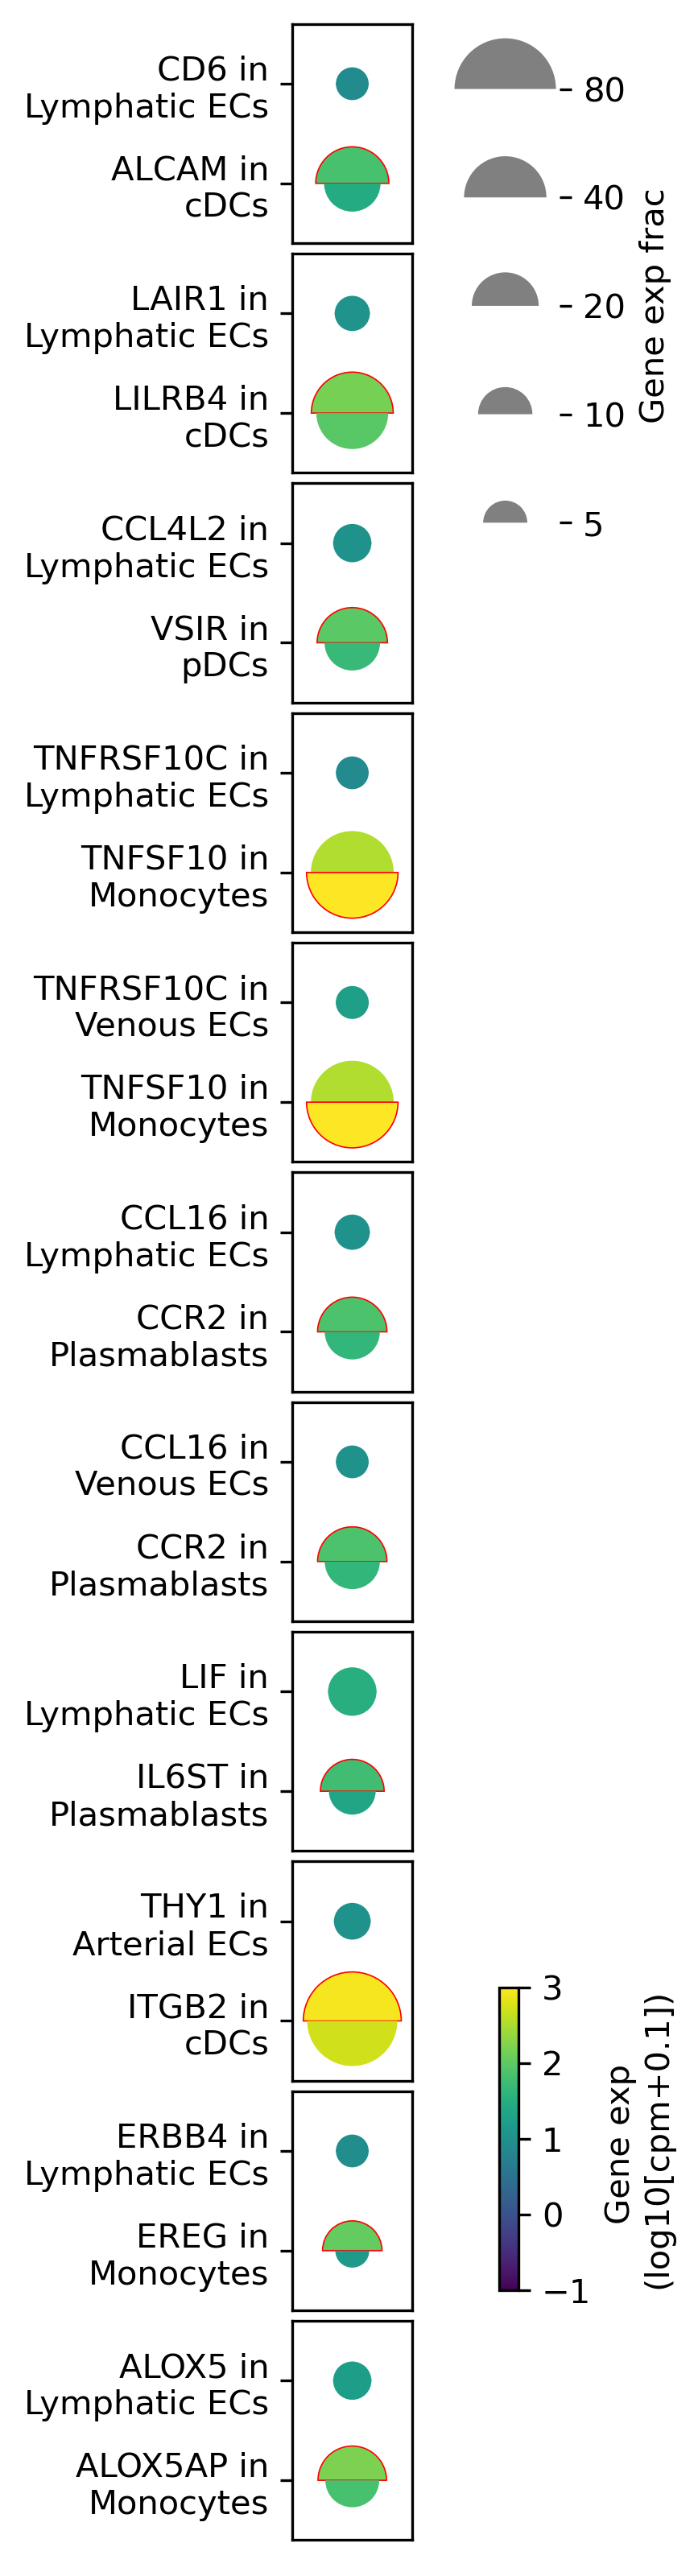

In [341]:
ls = []
for cta, ga, gb, ctb in ed_cst_only:
    ls.append({ga: [cta], gb: [ctb]})
s_mushrooms(ls)